In [256]:
# common stats analysis stack
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import expit
import scipy.stats as stats
import itertools
import pingouin as pg
import xarray as xr


#scikit learn
from sklearn.linear_model import LogisticRegression

# formulat interface to statsmodels (standard linear models)
import statsmodels.api as sm
import statsmodels.formula.api as smf
# BAyesian Model-building Interface (BAMBI)
import bambi as bmb
import arviz as az
# give me 0.95 HDIs as default
az.rcParams["stats.hdi_prob"] = 0.95

# for printing pretty tables and plots
from tabulate import tabulate
from  matplotlib.ticker import FuncFormatter, MaxNLocator

# some stuff for making notebooks look nice
from IPython.core.display import HTML, Markdown, display

# seed RNG
np.random.seed(0)

# hate these things
import warnings
warnings.filterwarnings("ignore")

# display all columns of dataframes
pd.set_option('display.max_columns', None)

# display x rows of dataframes
pd.set_option('display.max_rows', 30) # set to None to show all rows

#median for rts 
func_dict = {"Median": np.median,
            "MAD_SD":stats.median_abs_deviation,
             }


# package for saving variables into tex for publishing
from LaTeXDatax import datax

# import the data
exp_df = pd.read_csv("cleandata/exp-08-02-2022.csv")
qdf = pd.read_csv("cleandata/q-08-02-2022.csv")

In [3]:
# add some helpful columns to the df
# make sure the columns are coded as their proper data types
# 

df = exp_df.loc[:,~exp_df.columns.str.match("Unnamed")]

df["ruleInt"]=df["ruleInt"].astype("Int64")
df["ruleStr"]=df["ruleInt"].replace({1:"I",2:"II", 3:"III", 4:"IV", 5:"V", 6:"VI"})
df["ruleStr"]=df["ruleStr"].astype("category")
# df["hit"] = df["hitormiss"].astype(int)
df["hitStr"]=df["hitormiss"].replace({False:"0",True:"1"}).astype("category")
df["subjid"]=df["subjid"].astype("category")
df["game"]=df["game"].astype("Int64")
df["trial"]=df["trial"].astype("Int64")

testdf = df.loc[(df["phase"]=="test")]
learndf = df.loc[(df["phase"]=="learn")]
taskdf = df.loc[(df["phase"]=="task")]

display(df.head())

,phase,subjid,incentive,rule,dimorder,dimvals,condition,counterbalance,block,trial,nrepeats,theorystim,actualstim,correct,resp,hitormiss,rt,testscore,timestop,lasttwodigits,bonusprob,bonus,ruleInt,ruleStr,expNum,iid,answervalue,game,ticketvalue,ticketcolor,blocktrial,bonustodate,totalbonustodate,ntrials,points,allcards,moreA,scoretodate,score,bonusvalue,win,hitStr
0,learn,0,2.0,3.0,5.0,3.0,3.0,43.0,1.0,1,2.0,6.0,5.0,0.0,0.0,True,3589.0,NaN,NaN,NaN,NaN,NaN,4,IV,0,0,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,learn,0,2.0,3.0,5.0,3.0,3.0,43.0,1.0,2,2.0,4.0,7.0,1.0,0.0,False,10256.0,NaN,NaN,NaN,NaN,NaN,4,IV,0,0,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,learn,0,2.0,3.0,5.0,3.0,3.0,43.0,1.0,3,2.0,7.0,4.0,0.0,0.0,True,11863.0,NaN,NaN,NaN,NaN,NaN,4,IV,0,0,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,learn,0,2.0,3.0,5.0,3.0,3.0,43.0,1.0,4,2.0,7.0,4.0,0.0,0.0,True,5234.0,NaN,NaN,NaN,NaN,NaN,4,IV,0,0,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,learn,0,2.0,3.0,5.0,3.0,3.0,43.0,1.0,5,2.0,5.0,6.0,0.0,1.0,False,4442.0,NaN,NaN,NaN,NaN,NaN,4,IV,0,0,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [201]:
# formatting for consistent and beautiful coloring. for default/no hues, use color="b" (black)
# mypalette = ["#66c2a5","#8da0cb","#e78ac3","#fc8d62","#a6d854","#ffd92f"]
# mypalette = ["#1b9e77","#d95f02","#e7298a","#7570b3","#66a61e","#e6ab02"]
mypalette=["#264653","#2a9d8f","#e9d8a6","#ee9b00","#bb3e03","#9b2226"]
sns.set_palette(mypalette)
pal = sns.color_palette(mypalette)

# where axis is like ax.xaxis or ax.yaxis
def integerize_ticks(axis):
    axis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

def plot_performance_over_rule(ax):
    ax.set_ylabel("Percent correct")
    ax.set_ylim([0.0,1])
    ax.axhline(0.5, ls='--',color="lightgrey",zorder=0)
    ax.set_xlabel("Categorization Rule Type")
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x+1))) # here we add one since rule is 0 indexed
    
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [374]:
def plot_perf_by_incentive(results,labellist,expnum):
    fig, ax = plt.subplots()

    az.plot_forest(
        results,
        var_names=["incentive"],
        filter_vars="regex",
        hdi_prob=0.95,
        combined=True,
        colors="k",
        ax=ax
    )

    #reverse since it labels from bottom to top
    # ax.set_yticklabels(["Incentive: I","Incentive: II","Incentive: III","Incentive: IV","Incentive: V","Incentive: VI"].reverse())
    ax.set_yticklabels(labellist[::-1])
    ax.set_title("Exp. " + str(expnum) + " Regression Coefs. of Incentive on Performance")
    ax.axvline(0,color="lightgrey",zorder=0)

def plot_perf_by_ruletype(results,rulelist,expnum):
    fig, ax = plt.subplots()

    az.plot_forest(
        results,
        var_names=["Intercept","ruleStr"],
        hdi_prob=0.95,
        combined=True,
        colors="k",
        ax=ax
    )

    #reverse since it labels from bottom to top
    ax.set_yticklabels(rulelist[::-1])
    ax.set_title("Exp. " + str(expnum) + " Regression Coefs. of Rule Type on Performance")
    ax.axvline(0,color="lightgrey",zorder=0)

In [387]:
def plot_rt_by_rule(results_learn, results_test, labellist, expnum):
    fig, ax = plt.subplots(1,2,sharey=True,figsize=(10,4))

    az.plot_forest(
        results_learn,
        var_names=["Intercept","ruleStr"],
        hdi_prob=0.95,
        combined=True,
        colors="k",
        ax=ax[0]
    )

    #reverse since it labels from bottom to top
    # ax.set_yticklabels(["Incentive: I","Incentive: II","Incentive: III","Incentive: IV","Incentive: V","Incentive: VI"].reverse())
    ax[0].set_yticklabels(labellist[::-1])
    ax[0].set_title("Learning phase")
    ax[0].axvline(0,color="lightgrey",zorder=0)

    az.plot_forest(
        results_test,
        var_names=["Intercept","ruleStr"],
        hdi_prob=0.95,
        combined=True,
        colors="k",
        ax=ax[1]
    )

    ax[1].set_yticklabels(labellist[::-1])
    ax[1].set_title("Test phase")
    ax[1].axvline(0,color="lightgrey",zorder=0)
    fig.suptitle("Exp. " + str(expnum) + " Regression Coefs. of Rule Type on Response Time")

    plt.tight_layout()
    plt.show()

def plot_rt_by_incentive(results_learn, results_test, labellist, expnum):
    fig, ax = plt.subplots(1,2,sharey=True,figsize=(10,4))

    az.plot_forest(
        results_learn,
        var_names=["incentive"],
        filter_vars="regex",
        hdi_prob=0.95,
        combined=True,
        colors="k",
        ax=ax[0]
    )

    #reverse since it labels from bottom to top
    # ax[0].set_yticklabels(["Incentive:I","Incentive:II","Incentive:III","Incentive:IV","Incentive:V","Incentive:VI"][::-1])
    ax[0].set_yticklabels(labellist[::-1])
    ax[0].set_title("Learning phase")
    ax[0].axvline(0,color="lightgrey",zorder=0)

    az.plot_forest(
        results_test,
        var_names=["incentive"],
        filter_vars="regex",
        hdi_prob=0.95,
        combined=True,
        colors="k",
        ax=ax[1]
    )

    ax[1].set_yticklabels(labellist[::-1])
    ax[1].set_title("Test phase")
    ax[1].axvline(0,color="lightgrey",zorder=0)
    fig.suptitle("Exp. " + str(expnum) + " Regression Coefs. of Incentive on Response Time")

    plt.tight_layout()
    plt.show()

## Mixed logistic regression

### Experiment 1

In [4]:
# experiment 1 (0)
testdata0 = testdf.loc[testdf["expNum"]==0][["subjid","trial","ruleStr","incentive","hitStr","rt"]]
learndata0 = learndf.loc[learndf["expNum"]==0][["subjid","trial","ruleStr","incentive","hitStr","rt"]]

testdata0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3344 entries, 16 to 10449
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   subjid     3344 non-null   category
 1   trial      3344 non-null   Int64   
 2   ruleStr    3344 non-null   category
 3   incentive  3344 non-null   float64 
 4   hitStr     3344 non-null   category
 5   rt         3344 non-null   float64 
dtypes: Int64(1), category(3), float64(2)
memory usage: 140.6 KB


In [5]:
# ------- performance by rule
print("Performance by rule and incentive")

model0 = bmb.Model('hitStr["1"] ~ ruleStr * incentive', testdata0, family="bernoulli")
print(model0)
results0 = model0.fit(draws=1000, chains=4)
coefs0 = az.summary(results0)
coefs0

Performance by rule and incentive (no interaction)
Formula: hitStr["1"] ~ ruleStr * incentive
Family name: Bernoulli
Link: logit
Observations: 3344
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 5.2774)
    ruleStr ~ Normal(mu: [0. 0. 0. 0. 0.], sigma: [6.5848 6.9877 6.5848 7.1302 6.417 ])
    incentive ~ Normal(mu: 0.0, sigma: 0.2078)
    ruleStr:incentive ~ Normal(mu: [0. 0. 0. 0. 0.], sigma: [0.3159 0.3275 0.3099 0.3419 0.3235])


Modeling the probability that hitStr==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, ruleStr, incentive, ruleStr:incentive]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 112 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.196,0.258,1.733,2.712,0.009,0.006,794.0,1303.0,1.0
ruleStr[II],-0.808,0.311,-1.398,-0.237,0.010,0.007,1026.0,1583.0,1.0
ruleStr[III],-1.097,0.316,-1.697,-0.513,0.010,0.007,1042.0,1567.0,1.0
ruleStr[IV],-0.756,0.315,-1.332,-0.146,0.010,0.007,990.0,1782.0,1.0
ruleStr[V],-1.044,0.312,-1.625,-0.451,0.010,0.007,994.0,1445.0,1.0
ruleStr[VI],-1.591,0.294,-2.112,-1.028,0.010,0.007,959.0,1456.0,1.0
incentive,0.016,0.013,-0.009,0.041,0.000,0.000,807.0,1336.0,1.0
ruleStr:incentive[II],-0.026,0.016,-0.054,0.004,0.000,0.000,1015.0,1556.0,1.0
ruleStr:incentive[III],-0.027,0.016,-0.056,0.003,0.000,0.000,1046.0,1559.0,1.0
ruleStr:incentive[IV],-0.026,0.016,-0.054,0.004,0.001,0.000,913.0,1570.0,1.0


Text(0.5, 1.0, 'Rule Type VI')

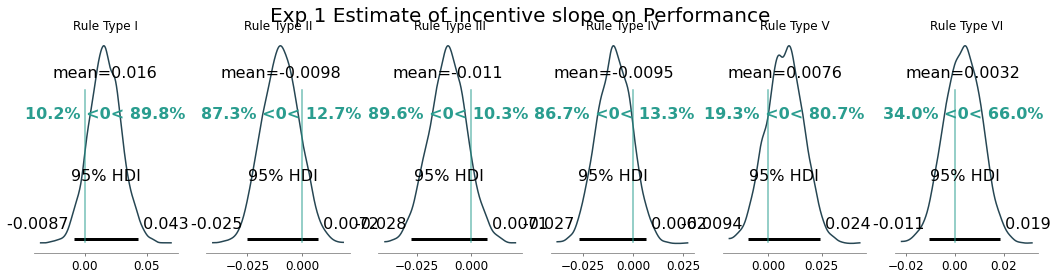

In [282]:
combo = results0.posterior["incentive"] + results0.posterior["ruleStr:incentive"] #.stack(samples=("chain", "draw"))
# comboIV = results5a.posterior["ticketvalue"] + results5a.posterior["ruleStr:ticketvalue"][1] #.stack(samples=("chain", "draw"))
fig, axes = plt.subplots(nrows=1,ncols=6,figsize=(18,4))
az.plot_posterior(results0.posterior["incentive"], hdi_prob=0.95, ref_val=0, ax=axes[0])
az.plot_posterior(combo[:,:,0], hdi_prob=0.95, ref_val=0, ax=axes[1])
az.plot_posterior(combo[:,:,1], hdi_prob=0.95, ref_val=0, ax=axes[2])
az.plot_posterior(combo[:,:,2], hdi_prob=0.95, ref_val=0, ax=axes[3])
az.plot_posterior(combo[:,:,3], hdi_prob=0.95, ref_val=0, ax=axes[4])
az.plot_posterior(combo[:,:,4], hdi_prob=0.95, ref_val=0, ax=axes[5])

fig.suptitle("Exp 1 Estimate of incentive slope on Performance")

axes[0].set_title("Rule Type I")
axes[1].set_title("Rule Type II")
axes[2].set_title("Rule Type III")
axes[3].set_title("Rule Type IV")
axes[4].set_title("Rule Type V")
axes[5].set_title("Rule Type VI")

In [296]:
# results0.posterior["incentive"]
results0stacked = results0.stack(sample=["chain", "draw"])
combo = results0stacked.posterior["incentive"] + results0stacked.posterior["ruleStr:incentive"] #.stack(samples=("chain", "draw"))

# results0stacked.posterior["incentive"], combo[:,0], combo[:,1], combo[:,2], combo[:,3], combo[:,4]

<xarray.DataArray 'incentive' (sample: 4000)>
array([ 0.00336543,  0.01804142,  0.01290513, ..., -0.0042185 ,
       -0.008021  ,  0.02037612])
Coordinates:
  * sample   (sample) MultiIndex
  - chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3
  - draw     (sample) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999

In [ ]:
# ------- response time
print("Response time by incentive")

model0rt_test = bmb.Model('rt ~ incentive * ruleStr', testdata0)
results0rt_test = model0rt_test.fit(draws=1000, chains=4)
az.summary(results0rt_test, stat_funcs=func_dict, extend=True)

Response time by incentive


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, incentive, ruleStr, incentive:ruleStr, rt_sigma]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 97 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,Median,MAD_SD
Intercept,1468.505,344.767,827.552,2112.628,9.555,6.758,1304.0,1865.0,1.0,1469.051,235.376
incentive,15.998,16.123,-13.551,46.926,0.463,0.328,1212.0,1963.0,1.0,15.997,10.862
ruleStr[II],1279.754,474.902,382.602,2152.458,11.697,8.288,1649.0,2201.0,1.0,1289.421,317.560
ruleStr[III],1959.910,504.739,1021.012,2917.226,12.222,8.644,1708.0,2240.0,1.0,1964.659,337.937
ruleStr[IV],1354.988,481.958,442.362,2248.551,12.393,8.793,1514.0,2026.0,1.0,1348.695,321.153
ruleStr[V],1923.259,470.355,1028.022,2792.237,11.294,7.987,1743.0,2282.0,1.0,1919.970,309.434
ruleStr[VI],1442.650,462.378,539.822,2277.065,11.491,8.170,1621.0,2044.0,1.0,1454.997,305.949
incentive:ruleStr[II],-29.822,22.903,-74.346,10.688,0.572,0.405,1604.0,2519.0,1.0,-29.672,15.693
incentive:ruleStr[III],-46.556,23.986,-91.921,-2.819,0.595,0.421,1624.0,2298.0,1.0,-46.837,16.055
incentive:ruleStr[IV],-2.267,22.903,-46.932,39.571,0.602,0.425,1452.0,2139.0,1.0,-2.434,15.099


In [ ]:
print("LEARNING phase response time data")
model0rt_learn = bmb.Model('rt ~ incentive * ruleStr', learndata0)
results0rt_learn = model0rt_learn.fit(draws=1000, chains=4)
az.summary(results0rt_learn, stat_funcs=func_dict, extend=True)

LEARNING phase response time data


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, incentive, ruleStr, incentive:ruleStr, rt_sigma]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 113 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,Median,MAD_SD
Intercept,2096.169,1033.256,285.305,4129.267,29.076,20.565,1262.0,1906.0,1.0,2122.203,694.955
incentive,27.813,47.921,-61.742,119.062,1.375,0.973,1215.0,1778.0,1.0,27.626,32.556
ruleStr[II],1824.324,1443.331,-900.153,4501.582,35.802,25.321,1627.0,2241.0,1.0,1806.429,953.996
ruleStr[III],3246.468,1522.533,254.863,5971.233,36.493,26.022,1741.0,2210.0,1.0,3233.990,1015.601
ruleStr[IV],2021.860,1456.360,-704.324,4741.844,35.944,25.421,1644.0,2072.0,1.0,2033.503,975.306
ruleStr[V],4058.534,1458.170,1257.868,6792.599,35.574,25.159,1681.0,2428.0,1.0,4064.396,984.887
ruleStr[VI],2203.549,1398.946,-313.345,4884.369,34.684,24.530,1630.0,2112.0,1.0,2191.275,964.839
incentive:ruleStr[II],-51.654,69.273,-181.052,80.456,1.724,1.219,1620.0,2145.0,1.0,-51.859,46.088
incentive:ruleStr[III],-56.089,71.510,-190.942,78.129,1.719,1.216,1729.0,2377.0,1.0,-56.557,48.029
incentive:ruleStr[IV],-60.800,68.872,-189.935,71.747,1.714,1.213,1614.0,2169.0,1.0,-61.311,46.859


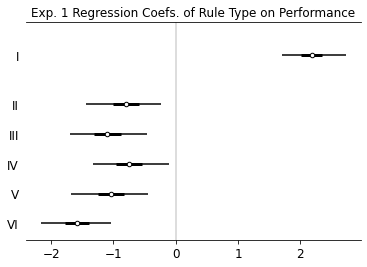

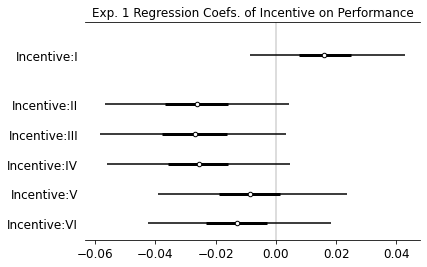

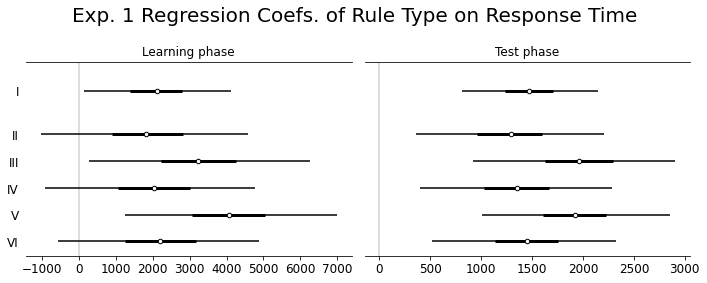

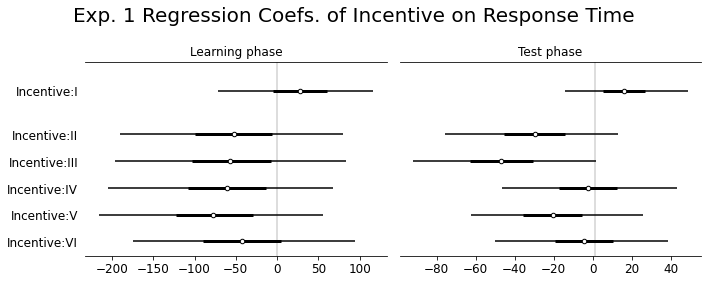

In [381]:
plot_perf_by_ruletype(results0,["I","II","III","IV","V","VI"],1)
plot_perf_by_incentive(results0,["Incentive:I","Incentive:II","Incentive:III","Incentive:IV","Incentive:V","Incentive:VI"],1)

plot_rt_by_rule(results0rt_learn, results0rt_test, ["I","II","III","IV","V","VI"], 1)
plot_rt_by_incentive(results0rt_learn, results0rt_test, ["Incentive:I","Incentive:II","Incentive:III","Incentive:IV","Incentive:V","Incentive:VI"], 1)

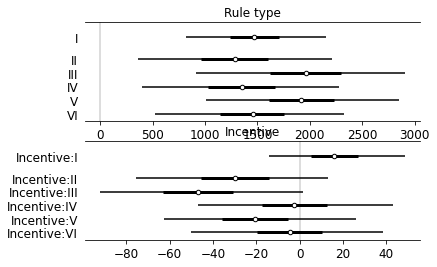

In [523]:
fig, ax = plt.subplots(2,1)

az.plot_forest(
    results0rt_test,
    var_names=["Intercept","ruleStr"],
    hdi_prob=0.95,
    combined=True,
    colors="k",
    ax=ax[0]
)

ax[0].axvline(0,color="lightgrey",zorder=0)
ax[0].set_yticklabels(["I","II","III","IV","V","VI"][::-1])
ax[0].set_title("Rule type")


az.plot_forest(
    results0rt_test,
    var_names=["incentive"],
    filter_vars="regex",
    hdi_prob=0.95,
    combined=True,
    colors="k",
    ax=ax[1]
)

ax[1].set_yticklabels(["Incentive:I","Incentive:II","Incentive:III","Incentive:IV","Incentive:V","Incentive:VI"][::-1])
ax[1].set_title("Incentive")
ax[1].axvline(0,color="lightgrey",zorder=0)
# fig.suptitle("Exp. " + str(1) + " Regression Coefs. on Response Time")

# plt.tight_layout()
plt.show()

In [525]:
def plot_all_coefs(results, labels):
    fig, ax = plt.subplots(2,1)

    az.plot_forest(
        results,
        var_names=["Intercept","ruleStr"],
        hdi_prob=0.95,
        combined=True,
        colors="k",
        ax=ax[0]
    )

    ax[0].axvline(0,color="lightgrey",zorder=0)
    ax[0].set_yticklabels(labels[::-1])
    ax[0].set_title("") #("Rule type")


    az.plot_forest(
        results,
        var_names=["incentive"],
        filter_vars="regex",
        hdi_prob=0.95,
        combined=True,
        colors="k",
        ax=ax[1]
    )

    labellist = ["Incentive:"+a for a in labels]
    ax[1].set_yticklabels(labellist[::-1])
    ax[1].set_title("") #("Incentive")
    ax[1].axvline(0,color="lightgrey",zorder=0)
    # fig.suptitle("Exp. " + str(1) + " Regression Coefs. on Response Time")

    # plt.tight_layout()
    plt.show()

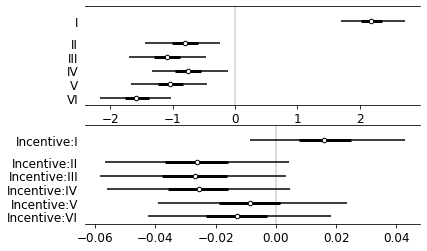

In [526]:
plot_all_coefs(results0,["I","II","III","IV","V","VI"])

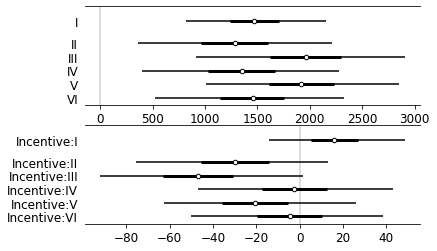

In [527]:
plot_all_coefs(results0rt_test,["I","II","III","IV","V","VI"])

In [408]:
# add posterior predictive group to results0
model0.predict(results0, kind='pps')


In [410]:
y_true = results0.observed_data["hitStr"].values
y_pred = results0.posterior_predictive.stack(sample=("chain", "draw"))["hitStr"].values.T
az.r2_score(y_true, y_pred)

r2        0.342461
r2_std    0.005408
dtype: float64

In [413]:
az.loo(results0)

Computed from 4000 posterior samples and 3344 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1743.73    30.06
p_loo       12.31        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3344  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

### Experiment 2

In [ ]:
# experiment 2
print("EXPERIMENT 2")

# experiment 2 (1)
testdata1 = testdf.loc[testdf["expNum"]==1][["subjid","trial","ruleStr","incentive","hitStr","rt"]]
learndata1 = learndf.loc[learndf["expNum"]==1][["subjid","trial","ruleStr","incentive","hitStr","rt"]]

# ------- performance by incentive
model1 = bmb.Model('hitStr["1"] ~ ruleStr * incentive', testdata1, family="bernoulli")
print(model1)
results1 = model1.fit(draws=1000, chains=4)
az.summary(results1)



Modeling the probability that hitStr==1


EXPERIMENT 2
Formula: hitStr["1"] ~ ruleStr * incentive
Family name: Bernoulli
Link: logit
Observations: 778
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 4.8528)
    ruleStr ~ Normal(mu: 0.0, sigma: 5.0003)
    incentive ~ Normal(mu: 0.0, sigma: 0.1667)
    ruleStr:incentive ~ Normal(mu: 0.0, sigma: 0.1775)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, ruleStr, incentive, ruleStr:incentive]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.925,0.218,1.540,2.349,0.005,0.003,2149.0,2228.0,1.0
ruleStr[IV],0.390,0.363,-0.328,1.029,0.008,0.006,2007.0,2080.0,1.0
incentive,-0.022,0.009,-0.039,-0.005,0.000,0.000,2189.0,2087.0,1.0
ruleStr:incentive[IV],0.004,0.014,-0.022,0.032,0.000,0.000,1881.0,2028.0,1.0


In [ ]:
# ------- reaction time
print("Response time by incentive")

model1rt_test = bmb.Model('rt ~ incentive * ruleStr', testdata1)
results1rt_test = model1rt_test.fit(draws=1000, chains=4)
az.summary(results1rt_test, stat_funcs=func_dict, extend=True)


Response time by incentive


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, incentive, ruleStr, incentive:ruleStr, rt_sigma]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,Median,MAD_SD
Intercept,2281.118,273.999,1797.604,2822.664,5.240,3.709,2729.0,2966.0,1.00,2285.795,187.702
incentive,24.467,12.678,1.073,48.605,0.246,0.174,2667.0,2354.0,1.00,24.539,8.799
ruleStr[IV],253.665,414.360,-517.912,995.019,8.416,5.953,2429.0,2750.0,1.00,254.406,287.034
incentive:ruleStr[IV],-19.741,18.115,-54.767,11.634,0.362,0.258,2505.0,2558.0,1.00,-19.807,12.501
rt_sigma,3727.203,94.858,3557.441,3910.487,1.576,1.115,3625.0,2464.0,1.01,3723.704,64.479


In [ ]:
print("LEARNING phase response time data")
model1rt_learn = bmb.Model('rt ~ incentive * ruleStr', learndata1)
results1rt_learn = model1rt_learn.fit(draws=1000, chains=4)
az.summary(results1rt_learn, stat_funcs=func_dict, extend=True)

LEARNING phase response time data


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, incentive, ruleStr, incentive:ruleStr, rt_sigma]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,Median,MAD_SD
Intercept,3211.116,304.261,2652.801,3777.313,5.875,4.169,2680.0,2517.0,1.0,3214.387,210.234
incentive,19.996,13.698,-4.854,46.229,0.263,0.186,2733.0,2752.0,1.0,19.977,9.322
ruleStr[IV],-572.336,447.066,-1420.443,262.586,8.733,6.468,2622.0,2461.0,1.0,-572.316,299.228
incentive:ruleStr[IV],-1.788,19.315,-37.624,34.618,0.393,0.334,2416.0,2273.0,1.0,-1.562,13.164
rt_sigma,7991.918,103.294,7797.897,8190.415,1.728,1.223,3588.0,2316.0,1.0,7990.825,67.833


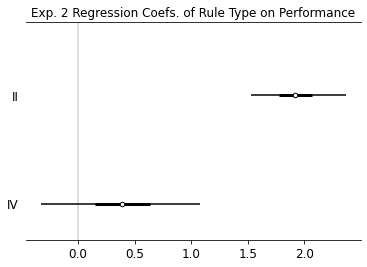

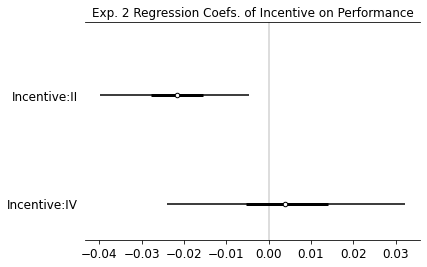

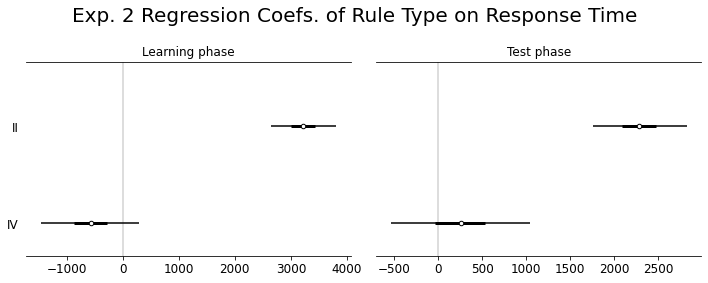

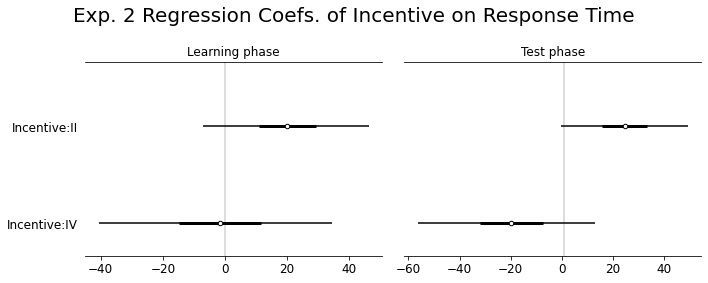

In [382]:
plot_perf_by_ruletype(results1,["II","IV"],2)
plot_perf_by_incentive(results1,["Incentive:II","Incentive:IV"],2)

plot_rt_by_rule(results1rt_learn, results1rt_test, ["II","IV"],2)
plot_rt_by_incentive(results1rt_learn, results1rt_test, ["Incentive:II","Incentive:IV"],2)

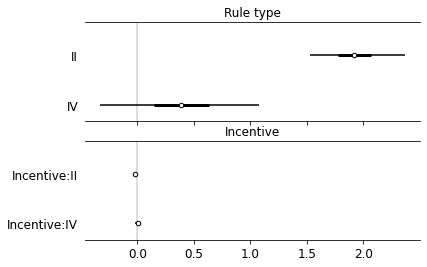

In [419]:
plot_all_coefs(results1,["II","IV"])

### Experiment 3

In [ ]:
# experiment 3

# experiment 3 (2)
testdata2 = testdf.loc[testdf["expNum"]==2][["subjid","trial","ruleStr","incentive","hitStr","rt"]]
learndata2 = learndf.loc[learndf["expNum"]==2][["subjid","trial","ruleStr","incentive","hitStr","rt"]]

# ------- performance by incentive
model2 = bmb.Model('hitStr["1"] ~ ruleStr * incentive', testdata2, family="bernoulli")
print(model2)
results2 = model2.fit(draws=1000, chains=4)
az.summary(results2)

Modeling the probability that hitStr==1


Formula: hitStr["1"] ~ ruleStr * incentive
Family name: Bernoulli
Link: logit
Observations: 744
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 4.8509)
    ruleStr ~ Normal(mu: 0.0, sigma: 5.0072)
    incentive ~ Normal(mu: 0.0, sigma: 0.1671)
    ruleStr:incentive ~ Normal(mu: 0.0, sigma: 0.1815)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, ruleStr, incentive, ruleStr:incentive]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.161,0.259,1.673,2.627,0.006,0.004,1773.0,1930.0,1.0
ruleStr[IV],-0.879,0.331,-1.516,-0.270,0.008,0.005,1911.0,1863.0,1.0
incentive,-0.019,0.010,-0.038,-0.002,0.000,0.000,1873.0,1745.0,1.0
ruleStr:incentive[IV],0.021,0.013,-0.004,0.046,0.000,0.000,1817.0,1778.0,1.0


Text(0.5, 1.0, 'Rule Type IV')

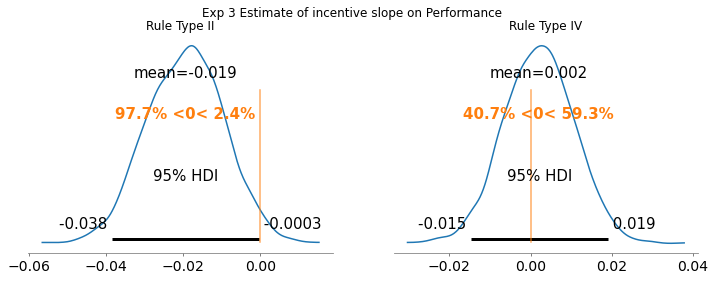

In [ ]:
combo = results2.posterior["incentive"] + results2.posterior["ruleStr:incentive"] #.stack(samples=("chain", "draw"))
# comboIV = results5a.posterior["ticketvalue"] + results5a.posterior["ruleStr:ticketvalue"][1] #.stack(samples=("chain", "draw"))
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
az.plot_posterior(results2.posterior["incentive"], hdi_prob=0.95, ref_val=0, ax=axes[0])
az.plot_posterior(combo, hdi_prob=0.95, ref_val=0, ax=axes[1])
# az.plot_posterior(combo[:,:,1], hdi_prob=0.95, ref_val=0, ax=axes[2])

fig.suptitle("Exp 3 Estimate of incentive slope on Performance")

axes[0].set_title("Rule Type II")
axes[1].set_title("Rule Type IV")

In [ ]:
# ------- reaction time
print("Response time by incentive")

model2rt_test = bmb.Model('rt ~ incentive * ruleStr', testdata2)
results2rt_test = model2rt_test.fit(draws=1000, chains=4)
az.summary(results2rt_test, stat_funcs=func_dict, extend=True)

Response time by incentive


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, incentive, ruleStr, incentive:ruleStr, rt_sigma]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,Median,MAD_SD
Intercept,3498.387,398.240,2719.197,4201.927,7.204,5.108,3061.0,3018.0,1.0,3504.422,268.344
incentive,2.390,17.374,-30.080,34.620,0.335,0.247,2683.0,2817.0,1.0,2.134,12.002
ruleStr[IV],-1203.619,596.241,-2288.833,-58.084,11.607,8.208,2646.0,2798.0,1.0,-1205.052,407.299
incentive:ruleStr[IV],24.503,25.424,-23.816,69.463,0.522,0.379,2377.0,2674.0,1.0,24.510,17.689
rt_sigma,4931.318,128.347,4680.559,5161.661,2.072,1.466,3831.0,2963.0,1.0,4931.345,86.523


Text(0.5, 1.0, 'Rule Type IV')

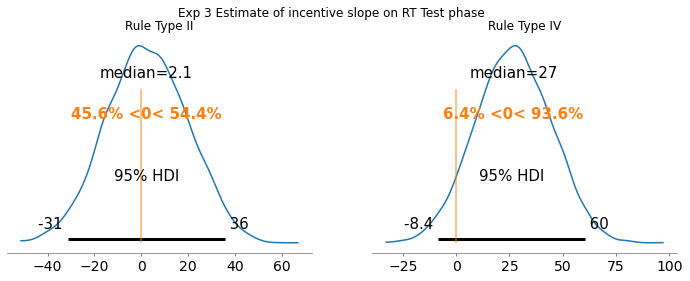

In [ ]:
combo = results2rt_test.posterior["incentive"] + results2rt_test.posterior["incentive:ruleStr"] #.stack(samples=("chain", "draw"))
# comboIV = results5a.posterior["ticketvalue"] + results5a.posterior["ruleStr:ticketvalue"][1] #.stack(samples=("chain", "draw"))
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
az.plot_posterior(results2rt_test.posterior["incentive"], point_estimate="median", hdi_prob=0.95, ref_val=0, ax=axes[0])
az.plot_posterior(combo, hdi_prob=0.95, point_estimate="median", ref_val=0, ax=axes[1])
# az.plot_posterior(combo[:,:,1], hdi_prob=0.95, ref_val=0, ax=axes[2])

fig.suptitle("Exp 3 Estimate of incentive slope on RT Test phase")

axes[0].set_title("Rule Type II")
axes[1].set_title("Rule Type IV")

In [ ]:
print("LEARNING phase response time data")
model2rt_learn = bmb.Model('rt ~ incentive * ruleStr', learndata2)
results2rt_learn = model2rt_learn.fit(draws=1000, chains=4)
az.summary(results2rt_learn, stat_funcs=func_dict, extend=True)

LEARNING phase response time data


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, incentive, ruleStr, incentive:ruleStr, rt_sigma]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1721 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,Median,MAD_SD
Intercept,4476.545,335.398,3834.959,5110.993,6.891,4.938,2357.0,2697.0,1.0,4478.114,220.873
incentive,-7.422,14.562,-32.655,22.193,0.278,0.213,2740.0,2711.0,1.0,-7.609,9.813
ruleStr[IV],-1460.753,502.944,-2377.790,-475.625,9.937,7.131,2571.0,2273.0,1.0,-1457.912,335.094
incentive:ruleStr[IV],32.569,21.441,-6.202,73.783,0.442,0.324,2361.0,2410.0,1.0,32.945,14.223
rt_sigma,8682.552,113.060,8466.849,8892.740,1.980,1.400,3259.0,2887.0,1.0,8680.714,75.615


Text(0.5, 1.0, 'Rule Type IV')

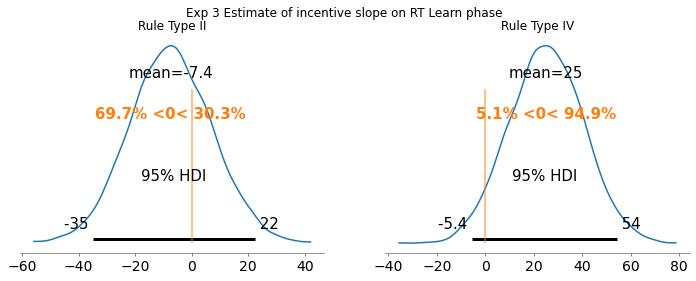

In [ ]:
combo = results2rt_learn.posterior["incentive"] + results2rt_learn.posterior["incentive:ruleStr"] #.stack(samples=("chain", "draw"))
# comboIV = results5a.posterior["ticketvalue"] + results5a.posterior["ruleStr:ticketvalue"][1] #.stack(samples=("chain", "draw"))
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
az.plot_posterior(results2rt_learn.posterior["incentive"], hdi_prob=0.95, ref_val=0, ax=axes[0])
az.plot_posterior(combo, hdi_prob=0.95, ref_val=0, ax=axes[1])
# az.plot_posterior(combo[:,:,1], hdi_prob=0.95, ref_val=0, ax=axes[2])

fig.suptitle("Exp 3 Estimate of incentive slope on RT Learn phase")

axes[0].set_title("Rule Type II")
axes[1].set_title("Rule Type IV")

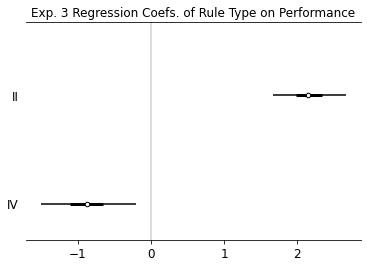

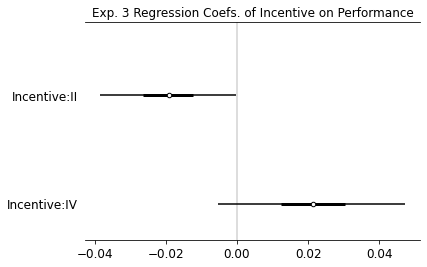

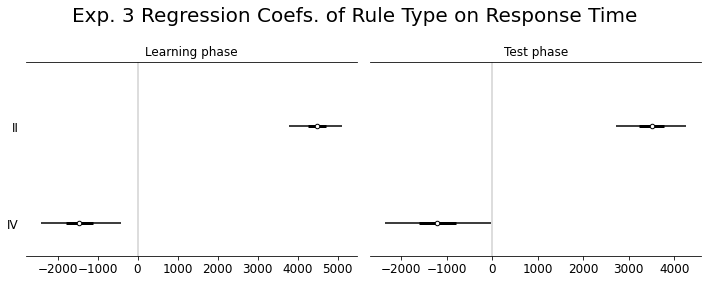

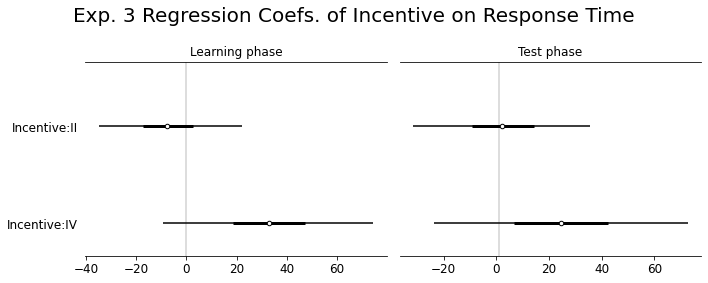

In [383]:
plot_perf_by_ruletype(results2,["II","IV"],3)
plot_perf_by_incentive(results2,["Incentive:II","Incentive:IV"],3)

plot_rt_by_rule(results2rt_learn, results2rt_test, ["II","IV"],3)
plot_rt_by_incentive(results2rt_learn, results2rt_test, ["Incentive:II","Incentive:IV"],3)

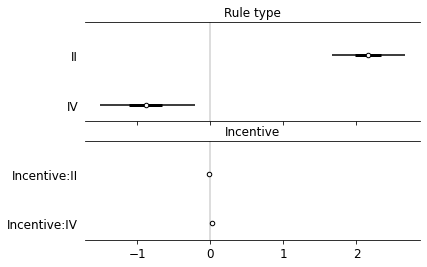

In [418]:
plot_all_coefs(results2,["II","IV"])

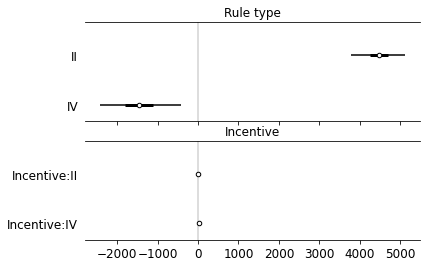

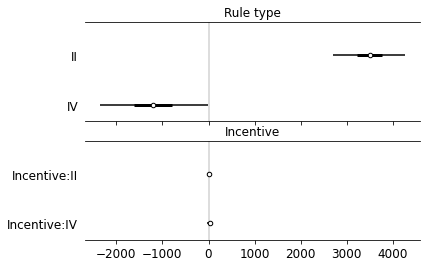

In [420]:
plot_all_coefs(results2rt_learn,["II","IV"])
plot_all_coefs(results2rt_test,["II","IV"])

### Experiment 4

WITHIN SUBJECTS. Each subj performs 4 blocks. Low vs High incentive crossed with Rule type II and IV.

TODO: This regression needs to consider the subject-level data accounting for the within design

In [ ]:
# experiment 4
# WITHIN SUBJECTS, so data frame looks a little different - each subject does 4 blocks

# experiment 4 (3)
testdata3 = testdf.loc[testdf["expNum"]==3][["subjid","trial","ruleStr","ticketvalue","hitStr","game","rt"]]
learndata3 = learndf.loc[learndf["expNum"]==3][["subjid","trial","ruleStr","ticketvalue","hitStr","game","rt"]]

# ------- performance by incentive
model3 = bmb.Model('hitStr["1"] ~ ruleStr * ticketvalue + (ruleStr|subjid) + (ticketvalue|subjid)', testdata3, family="bernoulli")
print(model3)
results3 = model3.fit(draws=1000, chains=4)
az.summary(results3)


Formula: hitStr["1"] ~ ruleStr * ticketvalue + (ruleStr|subjid) + (ticketvalue|subjid)
Family name: Bernoulli
Link: logit
Observations: 992
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 4.62)
    ruleStr ~ Normal(mu: 0.0, sigma: 5.0)
    ticketvalue ~ Normal(mu: 0.0, sigma: 4.1322)
    ruleStr:ticketvalue ~ Normal(mu: 0.0, sigma: 4.7189)

  Group-level effects
    1|subjid ~ Normal(mu: 0, sigma: HalfNormal(sigma: 4.62))
    ruleStr|subjid ~ Normal(mu: 0, sigma: HalfNormal(sigma: 5.0))
    ticketvalue|subjid ~ Normal(mu: 0, sigma: HalfNormal(sigma: 4.1322))


Modeling the probability that hitStr==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, ruleStr, ticketvalue, ruleStr:ticketvalue, 1|subjid_sigma, 1|subjid_offset, ruleStr|subjid_sigma, ruleStr|subjid_offset, ticketvalue|subjid_sigma, ticketvalue|subjid_offset]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 133 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.982,0.420,1.232,2.804,0.016,0.011,682.0,1022.0,1.01
ruleStr[IV],-0.173,0.332,-0.847,0.407,0.008,0.006,1756.0,2278.0,1.00
ticketvalue,0.004,0.216,-0.407,0.404,0.005,0.003,2087.0,2344.0,1.00
ruleStr:ticketvalue[IV],-0.041,0.283,-0.557,0.494,0.006,0.004,2228.0,2856.0,1.00
1|subjid_sigma,1.873,0.363,1.244,2.567,0.011,0.008,1048.0,1572.0,1.00
...,...,...,...,...,...,...,...,...,...
ticketvalue|subjid[30],-0.061,0.274,-0.669,0.416,0.005,0.004,3206.0,2171.0,1.00
ticketvalue|subjid[31],0.087,0.246,-0.332,0.632,0.005,0.004,3112.0,2796.0,1.00
ticketvalue|subjid[32],0.042,0.294,-0.506,0.685,0.006,0.006,3362.0,2223.0,1.00
ticketvalue|subjid[34],0.033,0.276,-0.456,0.675,0.005,0.005,2929.0,2172.0,1.00


Text(0.5, 1.0, 'Rule Type IV')

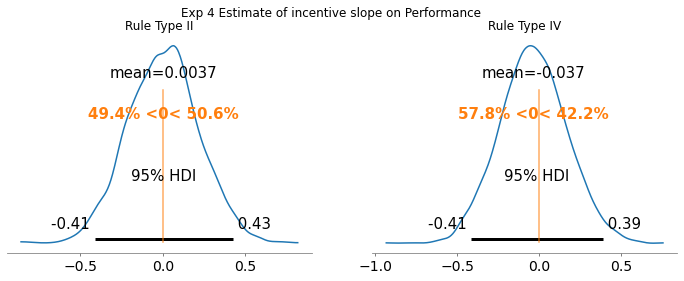

In [ ]:
combo = results3.posterior["ticketvalue"] + results3.posterior["ruleStr:ticketvalue"] #.stack(samples=("chain", "draw"))
# comboIV = results5a.posterior["ticketvalue"] + results5a.posterior["ruleStr:ticketvalue"][1] #.stack(samples=("chain", "draw"))
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
az.plot_posterior(results3.posterior["ticketvalue"], hdi_prob=0.95, ref_val=0, ax=axes[0])
az.plot_posterior(combo, hdi_prob=0.95, ref_val=0, ax=axes[1])
# az.plot_posterior(combo[:,:,1], hdi_prob=0.95, ref_val=0, ax=axes[2])

fig.suptitle("Exp 4 Estimate of incentive slope on Performance")

axes[0].set_title("Rule Type II")
axes[1].set_title("Rule Type IV")

In [ ]:
# # ------- performance by game
# print(testdata3["game"].unique())
# model3game = bmb.Model('hitStr["1"] ~ game + (game|subjid)', testdata3, family="bernoulli")
# print(model3game)
# results3game = model3game.fit(draws=1000, chains=4)
# az.summary(results3game)


In [ ]:
# ------- reaction time
print("Response time by incentive")

model3rt_test = bmb.Model('rt ~ ruleStr * ticketvalue + (ruleStr|subjid) + (ticketvalue|subjid)', testdata3)
results3rt_test = model3rt_test.fit(draws=1000, chains=4)
az.summary(results3rt_test, stat_funcs=func_dict, extend=True)

Response time by incentive


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, ruleStr, ticketvalue, ruleStr:ticketvalue, 1|subjid_sigma, 1|subjid_offset, ruleStr|subjid_sigma, ruleStr|subjid_offset, ticketvalue|subjid_sigma, ticketvalue|subjid_offset, rt_sigma]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 131 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,Median,MAD_SD
Intercept,5275.984,1230.478,3088.346,7701.530,21.017,14.863,3423.0,3111.0,1.0,5242.183,802.632
ruleStr[IV],-2290.492,1584.535,-5299.447,580.638,27.914,19.985,3215.0,2824.0,1.0,-2319.932,1073.820
ticketvalue,-1155.878,1261.156,-3523.566,1255.371,21.898,15.907,3319.0,2570.0,1.0,-1144.420,851.208
ruleStr:ticketvalue[IV],1544.642,1776.945,-1747.253,4744.538,32.569,24.158,2988.0,2563.0,1.0,1563.365,1268.744
1|subjid_sigma,2505.773,996.337,300.944,4181.646,36.798,26.030,742.0,659.0,1.0,2522.536,619.226
...,...,...,...,...,...,...,...,...,...,...,...
ticketvalue|subjid[30],-81.989,1122.507,-2311.418,2225.533,19.102,16.787,3765.0,2482.0,1.0,-11.740,460.541
ticketvalue|subjid[31],-82.419,1142.817,-2630.147,2041.683,18.149,15.383,4292.0,2715.0,1.0,-18.371,459.693
ticketvalue|subjid[32],71.106,1100.786,-2079.119,2499.582,19.191,17.718,3764.0,2222.0,1.0,14.072,431.608
ticketvalue|subjid[34],-34.450,1062.039,-2104.921,2216.277,18.282,14.994,3625.0,2635.0,1.0,-6.719,440.592


Text(0.5, 1.0, 'Rule Type IV')

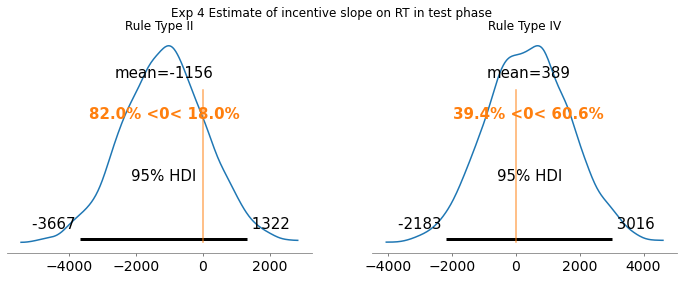

In [ ]:
combo = results3rt_test.posterior["ticketvalue"] + results3rt_test.posterior["ruleStr:ticketvalue"] #.stack(samples=("chain", "draw"))
# comboIV = results5a.posterior["ticketvalue"] + results5a.posterior["ruleStr:ticketvalue"][1] #.stack(samples=("chain", "draw"))
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
az.plot_posterior(results3rt_test.posterior["ticketvalue"], hdi_prob=0.95, ref_val=0, ax=axes[0])
az.plot_posterior(combo, hdi_prob=0.95, ref_val=0, ax=axes[1])
# az.plot_posterior(combo[:,:,1], hdi_prob=0.95, ref_val=0, ax=axes[2])

fig.suptitle("Exp 4 Estimate of incentive slope on RT in test phase")

axes[0].set_title("Rule Type II")
axes[1].set_title("Rule Type IV")
# axes[2].set_title("Rule Type IV")

In [ ]:
# ------- reaction time
print("Response time in learning phase")

model3rt_learn = bmb.Model('rt ~ ruleStr * ticketvalue + (ruleStr|subjid) + (ticketvalue|subjid)', learndata3)
results3rt_learn = model3rt_learn.fit(draws=1000, chains=4)
az.summary(results3rt_learn, stat_funcs=func_dict, extend=True)

Response time in learning phase


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, ruleStr, ticketvalue, ruleStr:ticketvalue, 1|subjid_sigma, 1|subjid_offset, ruleStr|subjid_sigma, ruleStr|subjid_offset, ticketvalue|subjid_sigma, ticketvalue|subjid_offset, rt_sigma]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 175 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,Median,MAD_SD
Intercept,5257.421,1085.694,3283.691,7291.896,27.201,19.348,1595.0,2215.0,1.00,5220.851,726.968
ruleStr[IV],-1402.809,1233.229,-3671.904,958.664,25.598,19.341,2335.0,2404.0,1.00,-1374.023,822.638
ticketvalue,-1442.269,1019.934,-3420.482,418.671,22.339,16.544,2087.0,2209.0,1.00,-1437.773,703.445
ruleStr:ticketvalue[IV],603.930,1414.765,-2100.996,3184.777,31.319,23.795,2039.0,2235.0,1.00,583.512,976.301
1|subjid_sigma,3673.694,828.767,2142.351,5236.275,32.713,23.187,665.0,866.0,1.00,3596.458,530.066
...,...,...,...,...,...,...,...,...,...,...,...
ticketvalue|subjid[30],81.382,1221.843,-2476.774,2406.272,30.854,22.740,1727.0,1341.0,1.00,17.702,518.388
ticketvalue|subjid[31],-89.003,1176.612,-2620.331,2185.234,25.356,20.883,2410.0,1687.0,1.00,-33.787,537.676
ticketvalue|subjid[32],443.177,1303.095,-1964.472,3251.703,33.688,27.394,1805.0,1573.0,1.00,184.914,542.202
ticketvalue|subjid[34],-285.150,1279.485,-2988.073,2040.634,33.723,27.955,1745.0,1107.0,1.01,-78.197,532.704


Text(0.5, 1.0, 'Rule Type IV')

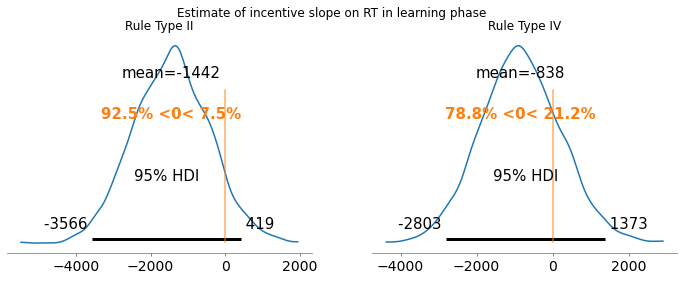

In [ ]:
combo = results3rt_learn.posterior["ticketvalue"] + results3rt_learn.posterior["ruleStr:ticketvalue"] #.stack(samples=("chain", "draw"))
# comboIV = results5a.posterior["ticketvalue"] + results5a.posterior["ruleStr:ticketvalue"][1] #.stack(samples=("chain", "draw"))
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
az.plot_posterior(results3rt_learn.posterior["ticketvalue"], hdi_prob=0.95, ref_val=0, ax=axes[0])
az.plot_posterior(combo, hdi_prob=0.95, ref_val=0, ax=axes[1])
# az.plot_posterior(combo[:,:,1], hdi_prob=0.95, ref_val=0, ax=axes[2])

fig.suptitle("Estimate of incentive slope on RT in learning phase")

# axes[0].set_title("Rule Type I")
axes[0].set_title("Rule Type II")
axes[1].set_title("Rule Type IV")

In [ ]:
plot_perf_by_ruletype(results1,["II","IV"],2)
plot_perf_by_incentive(results1,["Incentive:II","Incentive:IV"],2)

plot_rt_by_rule(results1rt_learn, results1rt_test, ["II","IV"],2)
plot_rt_by_incentive(results1rt_learn, results1rt_test, ["Incentive:II","Incentive:IV"],2)

### Experiment 5

category recognition task (no discovery)
once again, incentive is varied within subject

In [ ]:
# experiment 5 (4)
taskdata4 = taskdf.loc[taskdf["expNum"]==4][["subjid","trial","ruleStr","points","hitStr","rt"]]
# learndata4 = learndf.loc[learndf["expNum"]==4][["subjid","trial","ruleStr","ticketvalue","hitStr","rt"]]

taskdata4.head()


,subjid,trial,ruleStr,points,hitStr,rt
23329,0,0,I,16.0,1,26054.0
23330,0,1,I,2.0,1,20040.0
23331,0,2,I,1.0,1,15873.0
23332,0,3,I,2.0,1,21300.0
23333,0,4,I,4.0,1,15639.0


In [ ]:
# ------- performance by incentive
model4 = bmb.Model('hitStr["1"] ~ ruleStr * points + (points|subjid)', taskdata4, family="bernoulli")
print(model4)
results4 = model4.fit(draws=1000, chains=4)
coefs4 = az.summary(results4)
coefs4

Formula: hitStr["1"] ~ ruleStr * points + (points|subjid)
Family name: Bernoulli
Link: logit
Observations: 8000
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 4.0694)
    ruleStr ~ Normal(mu: [0. 0.], sigma: [5.3167 5.3167])
    points ~ Normal(mu: 0.0, sigma: 0.3317)
    ruleStr:points ~ Normal(mu: [0. 0.], sigma: [0.5074 0.5074])

  Group-level effects
    1|subjid ~ Normal(mu: 0, sigma: HalfNormal(sigma: 4.0694))
    points|subjid ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.3317))


Modeling the probability that hitStr==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, ruleStr, points, ruleStr:points, 1|subjid_sigma, 1|subjid_offset, points|subjid_sigma, points|subjid_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 270 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.457,0.170,1.122,1.770,0.009,0.006,393.0,754.0,1.01
ruleStr[II],-0.388,0.243,-0.859,0.052,0.014,0.010,299.0,622.0,1.02
ruleStr[IV],-0.693,0.237,-1.141,-0.259,0.012,0.009,368.0,847.0,1.01
points,0.022,0.009,0.007,0.039,0.000,0.000,742.0,939.0,1.01
ruleStr:points[II],0.009,0.012,-0.013,0.031,0.000,0.000,912.0,931.0,1.01
...,...,...,...,...,...,...,...,...,...
points|subjid[204],0.002,0.022,-0.040,0.047,0.001,0.000,1451.0,1231.0,1.00
points|subjid[205],0.013,0.023,-0.030,0.058,0.001,0.000,1548.0,1651.0,1.00
points|subjid[206],0.002,0.021,-0.040,0.043,0.001,0.000,1362.0,1084.0,1.00
points|subjid[207],-0.001,0.021,-0.042,0.042,0.001,0.000,1673.0,1531.0,1.00


In [533]:
# coefs4.loc[coefs4.index]
coefs4.iloc[0:30,:]

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.457,0.170,1.113,1.791,0.009,0.006,393.0,754.0,1.01
ruleStr[II],-0.388,0.243,-0.862,0.082,0.014,0.010,299.0,622.0,1.02
ruleStr[IV],-0.693,0.237,-1.144,-0.228,0.012,0.009,368.0,847.0,1.01
points,0.022,0.009,0.006,0.039,0.000,0.000,742.0,939.0,1.01
ruleStr:points[II],0.009,0.012,-0.013,0.032,0.000,0.000,912.0,931.0,1.01
ruleStr:points[IV],-0.000,0.011,-0.022,0.021,0.000,0.000,911.0,1229.0,1.00
1|subjid_sigma,1.352,0.086,1.194,1.530,0.003,0.002,634.0,937.0,1.01
points|subjid_sigma,0.024,0.010,0.003,0.041,0.000,0.000,386.0,610.0,1.01
1|subjid[0],2.169,0.824,0.625,3.803,0.018,0.013,2151.0,1795.0,1.00
1|subjid[1],-0.625,0.368,-1.345,0.087,0.012,0.009,897.0,1060.0,1.00


In [ ]:
allsubjs = taskdata4["subjid"].unique()

# do this to get the index of the subject (e.g., from between 0 and N=200 rather than the arbitrary subject id numbers that skip excluded subjs)
r1subjids = np.array([str(i) for i in taskdata4.query("ruleStr=='I'")["subjid"].unique()])
# r1subjs=[str(i) for i, x in enumerate(allsubjs) if x in r1subjids]
# print(r1subjids)

r2subjids = np.array([str(i) for i in taskdata4.query("ruleStr=='II'")["subjid"].unique()])

r4subjids = np.array([str(i) for i in taskdata4.query("ruleStr=='IV'")["subjid"].unique()])

# print(posterior["1|subjid"].sel(subjid__factor_dim=r1subjids))
# posterior

<xarray.Dataset>
Dimensions:              (sample: 4000, ruleStr_dim: 2, ruleStr:points_dim: 2, subjid__factor_dim: 200)
Coordinates:
  * ruleStr_dim          (ruleStr_dim) <U2 'II' 'IV'
  * ruleStr:points_dim   (ruleStr:points_dim) <U2 'II' 'IV'
  * subjid__factor_dim   (subjid__factor_dim) <U3 '0' '1' '2' ... '207' '209'
  * sample               (sample) MultiIndex
  - chain                (sample) int64 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3
  - draw                 (sample) int64 0 1 2 3 4 5 ... 994 995 996 997 998 999
Data variables:
    Intercept            (sample) float64 1.672 1.471 1.566 ... 1.776 1.837
    ruleStr              (ruleStr_dim, sample) float64 -0.8559 -0.8284 ... -1.31
    points               (sample) float64 0.02153 0.02845 ... 0.02844 0.02628
    ruleStr:points       (ruleStr:points_dim, sample) float64 0.002101 ... -0...
    1|subjid_sigma       (sample) float64 1.281 1.222 1.225 ... 1.369 1.377
    points|subjid_sigma  (sample) float64 0.03368 0.03722 ... 0.03125 0.04304
    1|subjid             (subjid__factor_dim, sample) float64 2.895 ... 0.2516
    points|subjid        (subjid__factor_dim, sample) float64 0.01256 ... 0.0...
Attributes:
    created_at:                  2022-08-16T19:28:40.312236
    arviz_version:               0.12.1
    inference_library:           pymc
    inference_library_version:   4.0.0
    sampling_time:               269.9298129081726
    tuning_steps:                1000
    modeling_interface:          bambi
    modeling_interface_version:  0.9.0

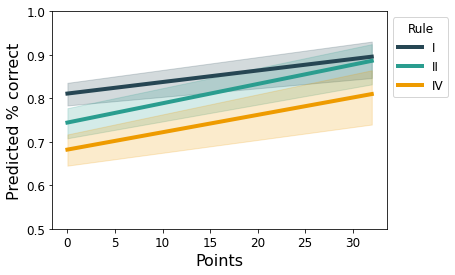

In [ ]:

incentive = np.array([0,32])
# print(incentive)

posterior = az.extract_dataset(results4)

# Intercept common
r1_common = posterior["Intercept"] 
r2_common = posterior["Intercept"] + posterior["ruleStr"][0]
r4_common = posterior["Intercept"] + posterior["ruleStr"][1]

# slope common
r1_slope_common = posterior["points"]
r2_slope_common = posterior["points"] + posterior["ruleStr:points"][0]
r4_slope_common = posterior["points"] + posterior["ruleStr:points"][1]

# intercept group specific
# rule_group_specific = posterior["1|subjid"] # separate by rule type
r1_group = posterior["1|subjid"].sel(subjid__factor_dim=r1subjids)
r2_group = posterior["1|subjid"].sel(subjid__factor_dim=r2subjids)
r4_group = posterior["1|subjid"].sel(subjid__factor_dim=r4subjids)

# slope group specific
r1_slope_group = posterior["points|subjid"].sel(subjid__factor_dim=r1subjids)
r2_slope_group = posterior["points|subjid"].sel(subjid__factor_dim=r2subjids)
r4_slope_group = posterior["points|subjid"].sel(subjid__factor_dim=r4subjids)

a1 = r1_common.mean() + r1_group.mean("sample")
b1 = r1_slope_common.mean() + r1_slope_group.mean("sample")

a2 = r2_common.mean() + r2_group.mean("sample")
b2 = r2_slope_common.mean() + r2_slope_group.mean("sample")

a4 = r4_common.mean() + r4_group.mean("sample")
b4 = r4_slope_common.mean() + r4_slope_group.mean("sample")

incentive_xi = xr.DataArray(incentive)

fig, ax = plt.subplots()
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="#264653", lw=4),
                Line2D([0], [0], color="#2a9d8f", lw=4),
                Line2D([0], [0], color="#ee9b00", lw=4)]

# # all subjects individual curves
# plt.plot(incentive, expit(a1 + b1 * incentive_xi).T, color="#264653", alpha=0.3, lw=1)
# plt.plot(incentive, expit(a2 + b2 * incentive_xi).T, color="#2a9d8f", alpha=0.3, lw=1)
# plt.plot(incentive, expit(a4 + b4 * incentive_xi).T, color="#ee9b00", alpha=0.3, lw=1)

# standard deviation bars
plt.fill_between(incentive_xi, expit(r1_common.mean() + r1_slope_common.mean() * incentive_xi - r1_common.std() - r1_slope_common.std()* incentive_xi).T, expit(r1_common.mean() + r1_slope_common.mean() * incentive_xi + r1_common.std() + r1_slope_common.std() * incentive_xi).T, color="#264653", alpha=0.2)
plt.fill_between(incentive_xi, expit(r2_common.mean() + r2_slope_common.mean() * incentive_xi - r2_common.std() - r2_slope_common.std()* incentive_xi).T, expit(r2_common.mean() + r2_slope_common.mean() * incentive_xi + r2_common.std() + r2_slope_common.std() * incentive_xi).T, color="#2a9d8f", alpha=0.2)
plt.fill_between(incentive_xi, expit(r4_common.mean() + r4_slope_common.mean() * incentive_xi - r4_common.std() - r4_slope_common.std()* incentive_xi).T, expit(r4_common.mean() + r4_slope_common.mean() * incentive_xi + r4_common.std() + r4_slope_common.std() * incentive_xi).T, color="#ee9b00", alpha=0.2)

# # HDI bars
# plt.fill_between(incentive_xi, expit(coefs4.loc["Intercept","hdi_3%"] + coefs4.loc["points","hdi_3%"] * incentive_xi).T, expit(coefs4.loc["Intercept","hdi_97%"] + coefs4.loc["points","hdi_97%"] * incentive_xi).T, color="#264653", alpha=0.2)
# plt.fill_between(incentive_xi, expit(coefs4.loc["Intercept","hdi_3%"] + coefs4.loc["ruleStr[II]","hdi_3%"] + (coefs4.loc["points","hdi_3%"] + coefs4.loc["ruleStr:points[II]","hdi_3%"]) * incentive_xi).T, expit(coefs4.loc["Intercept","hdi_97%"] + coefs4.loc["ruleStr[II]","hdi_97%"] + coefs4.loc["ruleStr:points[II]","hdi_97%"] * incentive_xi).T, color="#2a9d8f", alpha=0.2)
# plt.fill_between(incentive_xi, expit(coefs4.loc["Intercept","hdi_3%"] + coefs4.loc["ruleStr[IV]","hdi_3%"] + (coefs4.loc["points","hdi_3%"] + coefs4.loc["ruleStr:points[IV]","hdi_3%"]) * incentive_xi).T, expit(coefs4.loc["Intercept","hdi_97%"] + coefs4.loc["ruleStr[IV]","hdi_97%"] + coefs4.loc["ruleStr:points[IV]","hdi_97%"] * incentive_xi).T, color="#ee9b00", alpha=0.2)

# horizontal line at 0.5
# plt.plot([0,32],[0.5,0.5], ls='--',color="darkgrey",zorder=0, lw=2)

# average curves
plt.plot(incentive_xi, expit(r1_common.mean() + r1_slope_common.mean() * incentive_xi).T, color="#264653", alpha=1, lw=4)
plt.plot(incentive_xi, expit(r2_common.mean() + r2_slope_common.mean() * incentive_xi).T, color="#2a9d8f", alpha=1, lw=4)
plt.plot(incentive_xi, expit(r4_common.mean() + r4_slope_common.mean() * incentive_xi).T, color="#ee9b00", alpha=1, lw=4)

plt.ylim([0.5,1.0])
# 

plt.ylabel("Predicted % correct")
plt.xlabel("Points")
ax.legend(custom_lines, ['I', 'II', 'IV'],title="Rule",bbox_to_anchor=(1.2, 1))
# plt.gca().legend(title="Rule",bbox_to_anchor=(1.4, 1))

plt.show()

In [ ]:
# ------- performance by incentive

taskdata4["logpoints"] = np.log(taskdata4["points"]+1)
taskdata4

model4log = bmb.Model('hitStr["1"] ~ ruleStr * logpoints + (logpoints|subjid)', taskdata4, family="bernoulli")
print(model4log)
results4log = model4log.fit(draws=1000, chains=4)
coefs4log = az.summary(results4log)
coefs4log


Modeling the probability that hitStr==1


Formula: hitStr["1"] ~ ruleStr * logpoints + (logpoints|subjid)
Family name: Bernoulli
Link: logit
Observations: 8000
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 5.1114)
    ruleStr ~ Normal(mu: [0. 0.], sigma: [5.3167 5.3167])
    logpoints ~ Normal(mu: 0.0, sigma: 2.5638)
    ruleStr:logpoints ~ Normal(mu: [0. 0.], sigma: [3.0639 3.0639])

  Group-level effects
    1|subjid ~ Normal(mu: 0, sigma: HalfNormal(sigma: 5.1114))
    logpoints|subjid ~ Normal(mu: 0, sigma: HalfNormal(sigma: 2.5638))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, ruleStr, logpoints, ruleStr:logpoints, 1|subjid_sigma, 1|subjid_offset, logpoints|subjid_sigma, logpoints|subjid_offset]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 304 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.338,0.190,0.976,1.686,0.006,0.004,1083.0,1764.0,1.0
ruleStr[II],-0.431,0.264,-0.949,0.053,0.008,0.006,1116.0,1793.0,1.0
ruleStr[IV],-0.767,0.261,-1.264,-0.288,0.008,0.006,1024.0,1626.0,1.0
logpoints,0.190,0.075,0.056,0.337,0.002,0.001,1955.0,2054.0,1.0
ruleStr:logpoints[II],0.088,0.101,-0.102,0.275,0.002,0.002,2367.0,2216.0,1.0
...,...,...,...,...,...,...,...,...,...
logpoints|subjid[204],0.011,0.235,-0.428,0.456,0.004,0.003,3819.0,2956.0,1.0
logpoints|subjid[205],0.079,0.234,-0.372,0.516,0.003,0.003,4517.0,3175.0,1.0
logpoints|subjid[206],-0.032,0.235,-0.468,0.404,0.004,0.004,4379.0,2897.0,1.0
logpoints|subjid[207],0.056,0.233,-0.393,0.487,0.004,0.003,3715.0,3086.0,1.0


In [534]:
coefs4log.iloc[1:30,:]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ruleStr[II],-0.431,0.264,-0.949,0.053,0.008,0.006,1116.0,1793.0,1.00
ruleStr[IV],-0.767,0.261,-1.264,-0.288,0.008,0.006,1024.0,1626.0,1.00
logpoints,0.190,0.075,0.056,0.337,0.002,0.001,1955.0,2054.0,1.00
ruleStr:logpoints[II],0.088,0.101,-0.102,0.275,0.002,0.002,2367.0,2216.0,1.00
ruleStr:logpoints[IV],0.067,0.098,-0.110,0.254,0.002,0.002,2287.0,2181.0,1.00
1|subjid_sigma,1.300,0.091,1.131,1.473,0.002,0.002,1566.0,2460.0,1.00
logpoints|subjid_sigma,0.326,0.054,0.225,0.428,0.002,0.001,851.0,1330.0,1.01
1|subjid[0],2.042,0.838,0.509,3.683,0.012,0.010,4922.0,2985.0,1.00
1|subjid[1],-0.403,0.443,-1.241,0.408,0.009,0.006,2684.0,3022.0,1.00
1|subjid[2],1.518,0.629,0.366,2.699,0.009,0.007,4462.0,2987.0,1.00


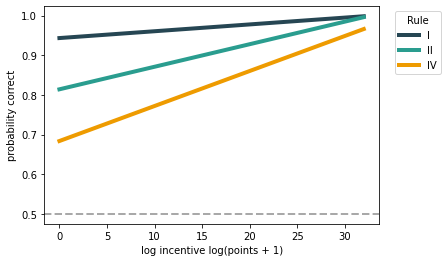

In [ ]:
incentive = np.array([0,32])
# print(incentive)

posterior = az.extract_dataset(results4log)

# Intercept common
r1_common = posterior["Intercept"] 
r2_common = posterior["Intercept"] + posterior["ruleStr"][0]
r4_common = posterior["Intercept"] + posterior["ruleStr"][1]

# slope common
r1_slope_common = posterior["logpoints"]
r2_slope_common = posterior["logpoints"] + posterior["ruleStr:logpoints"][0]
r4_slope_common = posterior["logpoints"] + posterior["ruleStr:logpoints"][1]

# intercept group specific
# rule_group_specific = posterior["1|subjid"] # separate by rule type
r1_group = posterior["1|subjid"].sel(subjid__factor_dim=r1subjids)
r2_group = posterior["1|subjid"].sel(subjid__factor_dim=r2subjids)
r4_group = posterior["1|subjid"].sel(subjid__factor_dim=r4subjids)

# slope group specific
r1_slope_group = posterior["logpoints|subjid"].sel(subjid__factor_dim=r1subjids)
r2_slope_group = posterior["logpoints|subjid"].sel(subjid__factor_dim=r2subjids)
r4_slope_group = posterior["logpoints|subjid"].sel(subjid__factor_dim=r4subjids)

a1 = r1_common.mean() + r1_group.mean("sample")
b1 = r1_slope_common.mean() + r1_slope_group.mean("sample")

a2 = r2_common.mean() + r2_group.mean("sample")
b2 = r2_slope_common.mean() + r2_slope_group.mean("sample")

a4 = r4_common.mean() + r4_group.mean("sample")
b4 = r4_slope_common.mean() + r4_slope_group.mean("sample")

incentive_xi = xr.DataArray(incentive)

fig, ax = plt.subplots()
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="#264653", lw=4),
                Line2D([0], [0], color="#2a9d8f", lw=4),
                Line2D([0], [0], color="#ee9b00", lw=4)]

# # all subjects individual curves
# plt.plot(incentive, expit(a1 + b1 * incentive_xi).T, color="#264653", alpha=0.3, lw=1)
# plt.plot(incentive, expit(a2 + b2 * incentive_xi).T, color="#2a9d8f", alpha=0.3, lw=1)
# plt.plot(incentive, expit(a4 + b4 * incentive_xi).T, color="#ee9b00", alpha=0.3, lw=1)

# # standard deviation bars
# plt.fill_between(incentive_xi, expit(r1_common.mean() + r1_slope_common.mean() * incentive_xi - r1_common.std() - r1_slope_common.std()* incentive_xi).T, expit(r1_common.mean() + r1_slope_common.mean() * incentive_xi + r1_common.std() + r1_slope_common.std() * incentive_xi).T, color="#264653", alpha=0.2)
# plt.fill_between(incentive_xi, expit(r2_common.mean() + r2_slope_common.mean() * incentive_xi - r2_common.std() - r2_slope_common.std()* incentive_xi).T, expit(r2_common.mean() + r2_slope_common.mean() * incentive_xi + r2_common.std() + r2_slope_common.std() * incentive_xi).T, color="#2a9d8f", alpha=0.2)
# plt.fill_between(incentive_xi, expit(r4_common.mean() + r4_slope_common.mean() * incentive_xi - r4_common.std() - r4_slope_common.std()* incentive_xi).T, expit(r4_common.mean() + r4_slope_common.mean() * incentive_xi + r4_common.std() + r4_slope_common.std() * incentive_xi).T, color="#ee9b00", alpha=0.2)

# # HDI bars
# plt.fill_between(incentive_xi, expit(coefs4log.loc["Intercept","hdi_3%"] + coefs4log.loc["points","hdi_3%"] * incentive_xi).T, expit(coefs4log.loc["Intercept","hdi_97%"] + coefs4.loc["points","hdi_97%"] * incentive_xi).T, color="#264653", alpha=0.2)
# plt.fill_between(incentive_xi, expit(coefs4log.loc["Intercept","hdi_3%"] + coefs4log.loc["ruleStr[II]","hdi_3%"] + (coefs4log.loc["points","hdi_3%"] + coefs4.loc["ruleStr:points[II]","hdi_3%"]) * incentive_xi).T, expit(coefs4log.loc["Intercept","hdi_97%"] + coefs4log.loc["ruleStr[II]","hdi_97%"] + coefs4log.loc["ruleStr:points[II]","hdi_97%"] * incentive_xi).T, color="#2a9d8f", alpha=0.2)
# plt.fill_between(incentive_xi, expit(coefs4log.loc["Intercept","hdi_3%"] + coefs4log.loc["ruleStr[IV]","hdi_3%"] + (coefs4log.loc["points","hdi_3%"] + coefs4.loc["ruleStr:points[IV]","hdi_3%"]) * incentive_xi).T, expit(coefs4log.loc["Intercept","hdi_97%"] + coefs4log.loc["ruleStr[IV]","hdi_97%"] + coefs4log.loc["ruleStr:points[IV]","hdi_97%"] * incentive_xi).T, color="#ee9b00", alpha=0.2)

# horizontal line at 0.5
# ax.axhline(0.5, ls='--',color="darkgrey",zorder=0, lw=2)

# average curves
# plt.plot(incentive_xi, expit(r1_common.mean() + r1_slope_common.mean() * (incentive_xi)).T, color="#264653", alpha=1, lw=4)
# plt.plot(incentive_xi, expit(r2_common.mean() + r2_slope_common.mean() * (incentive_xi)).T, color="#2a9d8f", alpha=1, lw=4)
# plt.plot(incentive_xi, expit(r4_common.mean() + r4_slope_common.mean() * (incentive_xi)).T, color="#ee9b00", alpha=1, lw=4)

# linear in log space
# plt.plot(np.log1p(incentive_xi), expit(r1_common.mean() + r1_slope_common.mean() * np.log1p(incentive_xi)).T, color="#264653", alpha=1, lw=4)
# plt.plot(np.log1p(incentive_xi), expit(r2_common.mean() + r2_slope_common.mean() * np.log1p(incentive_xi)).T, color="#2a9d8f", alpha=1, lw=4)
# plt.plot(np.log1p(incentive_xi), expit(r4_common.mean() + r4_slope_common.mean() * np.log1p(incentive_xi)).T, color="#ee9b00", alpha=1, lw=4)

# logistic in linear space
# r1term= ((incentive_xi + 1) ** r1_slope_common.mean()) * np.exp(r1_common.mean())
# plt.plot(incentive_xi, (r1term/(1+r1term)).T, color="#264653", alpha=1, lw=4)
plt.plot(incentive_xi, expit(np.expm1(r1_common.mean() + r1_slope_common.mean() * np.log1p(incentive_xi)).T), color="#264653", alpha=1, lw=4)
plt.plot(incentive_xi, expit(np.expm1(r2_common.mean() + r2_slope_common.mean() * np.log1p(incentive_xi)).T), color="#2a9d8f", alpha=1, lw=4)
plt.plot(incentive_xi, expit(np.expm1(r4_common.mean() + r4_slope_common.mean() * np.log1p(incentive_xi)).T), color="#ee9b00", alpha=1, lw=4)
# plt.plot(incentive_xi, expit(r2_common.mean() + r2_slope_common.mean() * np.log1p(incentive_xi)).T, color="#2a9d8f", alpha=1, lw=4)
# plt.plot(incentive_xi, expit(r4_common.mean() + r4_slope_common.mean() * np.log1p(incentive_xi)).T, color="#ee9b00", alpha=1, lw=4)

plt.ylim([0.5,1.0])
# 

plt.ylabel("probability correct")
plt.xlabel("log incentive log(points + 1)")
ax.legend(custom_lines, ['I', 'II', 'IV'],title="Rule",bbox_to_anchor=(1.2, 1))
# plt.gca().legend(title="Rule",bbox_to_anchor=(1.4, 1))

plt.show()

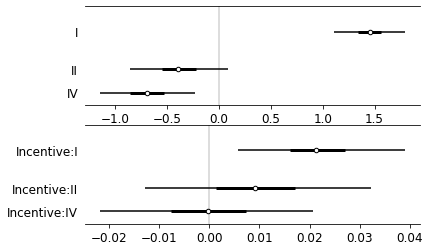

In [522]:
# plot_all_coefs(results4,["I","II","IV"])
labels=["I","II","IV"]
fig, ax = plt.subplots(2,1)

# az.plot_forest(results4)
az.plot_forest(
    results4,
    var_names=["Intercept","ruleStr"],
    hdi_prob=0.95,
    combined=True,
    colors="k",
    ax=ax[0]
)

ax[0].axvline(0,color="lightgrey",zorder=0)
ax[0].set_yticklabels(labels[::-1])
ax[0].set_title("")


az.plot_forest(
    results4,
    var_names=["points(?!.*j)"],#,"~subjid","~Intercept","~[II]"], #["~subjid",".*points.*^((?!j).)*$"], #["points","~subjid"], #["points(?!subjid)"],
    filter_vars="regex",
    hdi_prob=0.95,
    combined=True,
    colors="k",
    ax=ax[1]
)

# labels=["I","II","IV"]
# labellist = labels+ ["Incentive:"+a for a in labels]
labellist = ["Incentive:"+a for a in labels]

# print(labellist)
ax[1].set_yticklabels(labellist[::-1])
ax[1].set_title("")
ax[1].axvline(0,color="lightgrey",zorder=0)
# # fig.suptitle("Exp. " + str(1) + " Regression Coefs. on Response Time")

# plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Rule Type IV')

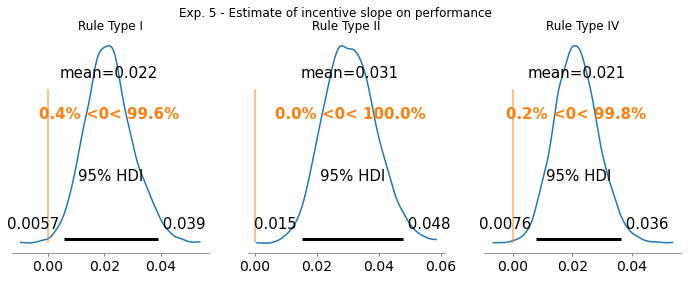

In [ ]:
combo = results4.posterior["points"] + results4.posterior["ruleStr:points"] #.stack(samples=("chain", "draw"))
# comboIV = results5a.posterior["ticketvalue"] + results5a.posterior["ruleStr:ticketvalue"][1] #.stack(samples=("chain", "draw"))
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
az.plot_posterior(results4.posterior["points"], hdi_prob=0.95, ref_val=0, ax=axes[0])
az.plot_posterior(combo[:,:,0], hdi_prob=0.95, ref_val=0, ax=axes[1])
az.plot_posterior(combo[:,:,1], hdi_prob=0.95, ref_val=0, ax=axes[2])

fig.suptitle("Exp. 5 - Estimate of incentive slope on performance")

axes[0].set_title("Rule Type I")
axes[1].set_title("Rule Type II")
axes[2].set_title("Rule Type IV")

In [ ]:
# ------- reaction time
print("Response time by incentive")

model4rt = bmb.Model('rt ~ ruleStr * points + (points|subjid)', taskdata4)
results4rt = model4rt.fit(draws=1000, chains=4)
az.summary(results4rt, stat_funcs=func_dict, extend=True)

Response time by incentive


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, ruleStr, points, ruleStr:points, 1|subjid_sigma, 1|subjid_offset, points|subjid_sigma, points|subjid_offset, rt_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 191 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,Median,MAD_SD
Intercept,11887.050,1811.215,8471.503,15284.895,86.730,61.368,435.0,798.0,1.01,11916.691,1232.409
ruleStr[II],4401.319,2511.752,-409.691,8937.626,112.524,79.613,498.0,903.0,1.00,4436.906,1703.500
ruleStr[IV],7097.025,2589.485,2049.536,11794.845,121.004,85.617,458.0,913.0,1.01,7109.536,1721.698
points,81.300,85.618,-71.694,240.083,2.783,1.969,947.0,1403.0,1.00,80.975,58.098
ruleStr:points[II],231.095,122.818,-8.690,453.845,3.615,2.557,1154.0,1762.0,1.00,232.534,83.629
...,...,...,...,...,...,...,...,...,...,...,...
points|subjid[204],-21.704,145.459,-337.481,239.644,4.858,4.557,1073.0,971.0,1.01,-7.352,62.079
points|subjid[205],17.856,139.414,-254.979,311.281,4.740,4.131,1072.0,810.0,1.01,5.594,61.074
points|subjid[206],-30.387,150.131,-356.363,252.840,4.834,3.921,1147.0,880.0,1.01,-9.093,61.714
points|subjid[207],-6.701,136.014,-265.918,274.796,4.330,3.308,1082.0,973.0,1.00,-0.221,60.726


Text(0.5, 1.0, 'Rule Type IV')

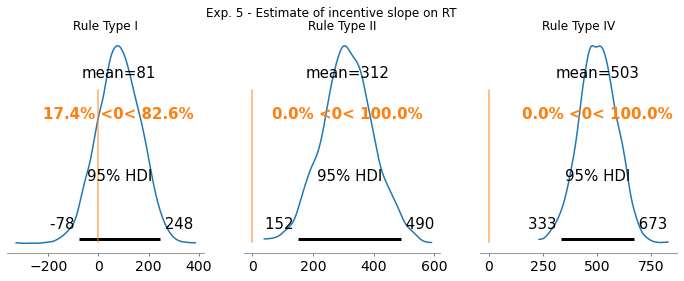

In [ ]:
combo = results4rt.posterior["points"] + results4rt.posterior["ruleStr:points"] #.stack(samples=("chain", "draw"))
# comboIV = results5a.posterior["ticketvalue"] + results5a.posterior["ruleStr:ticketvalue"][1] #.stack(samples=("chain", "draw"))
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
az.plot_posterior(results4rt.posterior["points"], hdi_prob=0.95, ref_val=0, ax=axes[0])
az.plot_posterior(combo[:,:,0], hdi_prob=0.95, ref_val=0, ax=axes[1])
az.plot_posterior(combo[:,:,1], hdi_prob=0.95, ref_val=0, ax=axes[2])

fig.suptitle("Exp. 5 - Estimate of incentive slope on RT")

axes[0].set_title("Rule Type I")
axes[1].set_title("Rule Type II")
axes[2].set_title("Rule Type IV")

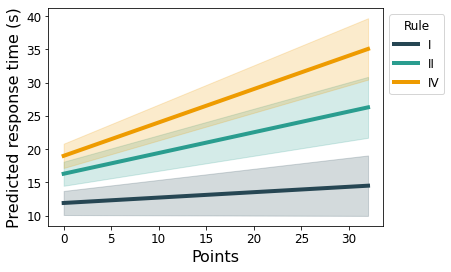

In [ ]:
incentive = np.array([0,32])
# print(incentive)

posterior = az.extract_dataset(results4rt)

# Intercept common
r1_common = posterior["Intercept"] 
r2_common = posterior["Intercept"] + posterior["ruleStr"][0]
r4_common = posterior["Intercept"] + posterior["ruleStr"][1]

# slope common
r1_slope_common = posterior["points"]
r2_slope_common = posterior["points"] + posterior["ruleStr:points"][0]
r4_slope_common = posterior["points"] + posterior["ruleStr:points"][1]

# intercept group specific
# rule_group_specific = posterior["1|subjid"] # separate by rule type
r1_group = posterior["1|subjid"].sel(subjid__factor_dim=r1subjids)
r2_group = posterior["1|subjid"].sel(subjid__factor_dim=r2subjids)
r4_group = posterior["1|subjid"].sel(subjid__factor_dim=r4subjids)

# slope group specific
r1_slope_group = posterior["points|subjid"].sel(subjid__factor_dim=r1subjids)
r2_slope_group = posterior["points|subjid"].sel(subjid__factor_dim=r2subjids)
r4_slope_group = posterior["points|subjid"].sel(subjid__factor_dim=r4subjids)

a1 = r1_common.mean() + r1_group.mean("sample")
b1 = r1_slope_common.mean() + r1_slope_group.mean("sample")

a2 = r2_common.mean() + r2_group.mean("sample")
b2 = r2_slope_common.mean() + r2_slope_group.mean("sample")

a4 = r4_common.mean() + r4_group.mean("sample")
b4 = r4_slope_common.mean() + r4_slope_group.mean("sample")

incentive_xi = xr.DataArray(incentive)

fig, ax = plt.subplots()
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="#264653", lw=4),
                Line2D([0], [0], color="#2a9d8f", lw=4),
                Line2D([0], [0], color="#ee9b00", lw=4)]

# # all subjects individual curves
# plt.plot(incentive, (a1 + b1 * incentive_xi).T, color="#264653", alpha=0.3, lw=1)
# plt.plot(incentive, (a2 + b2 * incentive_xi).T, color="#2a9d8f", alpha=0.3, lw=1)
# plt.plot(incentive, (a4 + b4 * incentive_xi).T, color="#ee9b00", alpha=0.3, lw=1)

# standard deviation bars
plt.fill_between(incentive_xi, .001 * (r1_common.mean() + r1_slope_common.mean() * incentive_xi - r1_common.std() - r1_slope_common.std()* incentive_xi).T,
 .001 * (r1_common.mean() + r1_slope_common.mean() * incentive_xi + r1_common.std() + r1_slope_common.std() * incentive_xi).T, color="#264653", alpha=0.2)
plt.fill_between(incentive_xi, .001 * (r2_common.mean() + r2_slope_common.mean() * incentive_xi - r2_common.std() - r2_slope_common.std()* incentive_xi).T,
 .001 * (r2_common.mean() + r2_slope_common.mean() * incentive_xi + r2_common.std() + r2_slope_common.std() * incentive_xi).T, color="#2a9d8f", alpha=0.2)
plt.fill_between(incentive_xi, .001 * (r4_common.mean() + r4_slope_common.mean() * incentive_xi - r4_common.std() - r4_slope_common.std()* incentive_xi).T,
 .001 * (r4_common.mean() + r4_slope_common.mean() * incentive_xi + r4_common.std() + r4_slope_common.std() * incentive_xi).T, color="#ee9b00", alpha=0.2)

# # HDI bars
# plt.fill_between(incentive_xi, expit(coefs4.loc["Intercept","hdi_3%"] + coefs4.loc["points","hdi_3%"] * incentive_xi).T, expit(coefs4.loc["Intercept","hdi_97%"] + coefs4.loc["points","hdi_97%"] * incentive_xi).T, color="#264653", alpha=0.2)
# plt.fill_between(incentive_xi, expit(coefs4.loc["Intercept","hdi_3%"] + coefs4.loc["ruleStr[II]","hdi_3%"] + (coefs4.loc["points","hdi_3%"] + coefs4.loc["ruleStr:points[II]","hdi_3%"]) * incentive_xi).T, expit(coefs4.loc["Intercept","hdi_97%"] + coefs4.loc["ruleStr[II]","hdi_97%"] + coefs4.loc["ruleStr:points[II]","hdi_97%"] * incentive_xi).T, color="#2a9d8f", alpha=0.2)
# plt.fill_between(incentive_xi, expit(coefs4.loc["Intercept","hdi_3%"] + coefs4.loc["ruleStr[IV]","hdi_3%"] + (coefs4.loc["points","hdi_3%"] + coefs4.loc["ruleStr:points[IV]","hdi_3%"]) * incentive_xi).T, expit(coefs4.loc["Intercept","hdi_97%"] + coefs4.loc["ruleStr[IV]","hdi_97%"] + coefs4.loc["ruleStr:points[IV]","hdi_97%"] * incentive_xi).T, color="#ee9b00", alpha=0.2)

# horizontal line at 0.5
# plt.plot([0,32],[0.5,0.5], ls='--',color="darkgrey",zorder=0, lw=2)

# average curves
plt.plot(incentive_xi, .001 * (r1_common.mean() + r1_slope_common.mean() * incentive_xi).T, color="#264653", alpha=1, lw=4)
plt.plot(incentive_xi, .001 * (r2_common.mean() + r2_slope_common.mean() * incentive_xi).T, color="#2a9d8f", alpha=1, lw=4)
plt.plot(incentive_xi, .001 * (r4_common.mean() + r4_slope_common.mean() * incentive_xi).T, color="#ee9b00", alpha=1, lw=4)

# plt.ylim([0.5,1.0])
# 

plt.ylabel("Predicted response time (s)")
plt.xlabel("Points")
ax.legend(custom_lines, ['I', 'II', 'IV'],title="Rule",bbox_to_anchor=(1.2, 1))
# plt.gca().legend(title="Rule",bbox_to_anchor=(1.4, 1))

plt.show()

In [ ]:
# ------- reaction time
print("Response time by incentive")

model4rtlog = bmb.Model('rt ~ ruleStr * logpoints + (logpoints|subjid)', taskdata4)
results4rtlog = model4rtlog.fit(draws=1000, chains=4)
az.summary(results4rtlog, stat_funcs=func_dict, extend=True)

Response time by incentive


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, ruleStr, logpoints, ruleStr:logpoints, 1|subjid_sigma, 1|subjid_offset, logpoints|subjid_sigma, logpoints|subjid_offset, rt_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 264 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,Median,MAD_SD
Intercept,10983.462,1865.089,7231.637,14250.376,73.002,51.643,655.0,1308.0,1.01,11009.125,1234.614
ruleStr[II],3239.575,2693.046,-1892.631,8167.710,161.708,128.587,273.0,586.0,1.03,3259.481,1799.810
ruleStr[IV],4457.911,2738.449,-649.383,9714.672,101.004,71.449,741.0,1178.0,1.01,4537.897,1824.188
logpoints,1030.301,716.894,-256.972,2440.271,20.270,15.048,1265.0,1564.0,1.01,1017.977,477.365
ruleStr:logpoints[II],1873.925,1063.092,-138.248,3802.188,27.520,19.463,1495.0,1890.0,1.01,1899.577,736.548
...,...,...,...,...,...,...,...,...,...,...,...
logpoints|subjid[204],-1481.323,2296.469,-5825.419,2774.360,64.189,45.399,1302.0,2326.0,1.01,-1256.027,1443.217
logpoints|subjid[205],433.869,2310.008,-3986.724,4945.934,54.259,55.340,1926.0,1003.0,1.00,362.387,1424.904
logpoints|subjid[206],-1499.444,2346.716,-5999.084,2719.374,64.843,55.754,1448.0,1377.0,1.00,-1281.604,1477.182
logpoints|subjid[207],-573.001,2313.731,-5235.573,3637.699,46.746,47.533,2481.0,1976.0,1.00,-484.981,1440.341


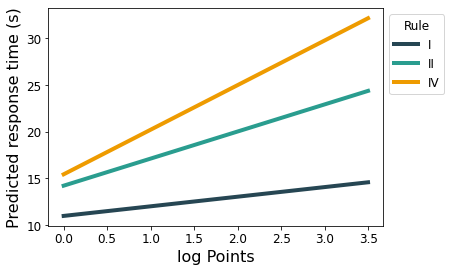

In [ ]:
incentive = np.array([0,32])
# print(incentive)

posterior = az.extract_dataset(results4rtlog)

# Intercept common
r1_common = posterior["Intercept"] 
r2_common = posterior["Intercept"] + posterior["ruleStr"][0]
r4_common = posterior["Intercept"] + posterior["ruleStr"][1]

# slope common
r1_slope_common = posterior["logpoints"]
r2_slope_common = posterior["logpoints"] + posterior["ruleStr:logpoints"][0]
r4_slope_common = posterior["logpoints"] + posterior["ruleStr:logpoints"][1]

# intercept group specific
# rule_group_specific = posterior["1|subjid"] # separate by rule type
r1_group = posterior["1|subjid"].sel(subjid__factor_dim=r1subjids)
r2_group = posterior["1|subjid"].sel(subjid__factor_dim=r2subjids)
r4_group = posterior["1|subjid"].sel(subjid__factor_dim=r4subjids)

# slope group specific
r1_slope_group = posterior["logpoints|subjid"].sel(subjid__factor_dim=r1subjids)
r2_slope_group = posterior["logpoints|subjid"].sel(subjid__factor_dim=r2subjids)
r4_slope_group = posterior["logpoints|subjid"].sel(subjid__factor_dim=r4subjids)

a1 = r1_common.mean() + r1_group.mean("sample")
b1 = r1_slope_common.mean() + r1_slope_group.mean("sample")

a2 = r2_common.mean() + r2_group.mean("sample")
b2 = r2_slope_common.mean() + r2_slope_group.mean("sample")

a4 = r4_common.mean() + r4_group.mean("sample")
b4 = r4_slope_common.mean() + r4_slope_group.mean("sample")

incentive_xi = xr.DataArray(incentive)

fig, ax = plt.subplots()
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="#264653", lw=4),
                Line2D([0], [0], color="#2a9d8f", lw=4),
                Line2D([0], [0], color="#ee9b00", lw=4)]

# # all subjects individual curves
# plt.plot(incentive, (a1 + b1 * incentive_xi).T, color="#264653", alpha=0.3, lw=1)
# plt.plot(incentive, (a2 + b2 * incentive_xi).T, color="#2a9d8f", alpha=0.3, lw=1)
# plt.plot(incentive, (a4 + b4 * incentive_xi).T, color="#ee9b00", alpha=0.3, lw=1)

# # standard deviation bars
# plt.fill_between(np.log1p(incentive_xi), .001 * (r1_common.mean() + r1_slope_common.mean() * np.log1p(incentive_xi) - r1_common.std() - r1_slope_common.std()* np.log1p(incentive_xi)).T,
#  .001 * (r1_common.mean() + r1_slope_common.mean() * np.log1p(incentive_xi) + r1_common.std() + r1_slope_common.std() * np.log1p(incentive_xi)).T, color="#264653", alpha=0.2)
# plt.fill_between(np.log1p(incentive_xi), .001 * (r2_common.mean() + r2_slope_common.mean() * np.log1p(incentive_xi) - r2_common.std() - r2_slope_common.std()* np.log1p(incentive_xi)).T,
#  .001 * (r2_common.mean() + r2_slope_common.mean() * np.log1p(incentive_xi) + r2_common.std() + r2_slope_common.std() * np.log1p(incentive_xi)).T, color="#2a9d8f", alpha=0.2)
# plt.fill_between(np.log1p(incentive_xi), .001 * (r4_common.mean() + r4_slope_common.mean() * np.log1p(incentive_xi) - r4_common.std() - r4_slope_common.std()* np.log1p(incentive_xi)).T,
#  .001 * (r4_common.mean() + r4_slope_common.mean() * np.log1p(incentive_xi) + r4_common.std() + r4_slope_common.std() * np.log1p(incentive_xi)).T, color="#ee9b00", alpha=0.2)


# average curves
# plt.plot(incentive_xi, .001 * (r1_common.mean() + r1_slope_common.mean() * incentive_xi).T, color="#264653", alpha=1, lw=4)
# plt.plot(incentive_xi, .001 * (r2_common.mean() + r2_slope_common.mean() * incentive_xi).T, color="#2a9d8f", alpha=1, lw=4)
# plt.plot(incentive_xi, .001 * (r4_common.mean() + r4_slope_common.mean() * incentive_xi).T, color="#ee9b00", alpha=1, lw=4)
# linear in log space
plt.plot(np.log1p(incentive_xi), (.001 * (r1_common.mean() + r1_slope_common.mean() * np.log1p(incentive_xi)).T), color="#264653", alpha=1, lw=4)
plt.plot(np.log1p(incentive_xi), (.001 * (r2_common.mean() + r2_slope_common.mean() * np.log1p(incentive_xi)).T), color="#2a9d8f", alpha=1, lw=4)
plt.plot(np.log1p(incentive_xi), (.001 * (r4_common.mean() + r4_slope_common.mean() * np.log1p(incentive_xi)).T), color="#ee9b00", alpha=1, lw=4)
# plt.plot(incentive_xi, (.001 * (r1_common.mean() + r1_slope_common.mean() * (incentive_xi)).T), color="#264653", alpha=1, lw=4)
# plt.plot(incentive_xi, (.001 * (r2_common.mean() + r2_slope_common.mean() * (incentive_xi)).T), color="#2a9d8f", alpha=1, lw=4)
# plt.plot(incentive_xi, (.001 * (r4_common.mean() + r4_slope_common.mean() * (incentive_xi)).T), color="#ee9b00", alpha=1, lw=4)


plt.ylabel("Predicted response time (s)")
plt.xlabel("log Points")
ax.legend(custom_lines, ['I', 'II', 'IV'],title="Rule",bbox_to_anchor=(1.2, 1))
# plt.gca().legend(title="Rule",bbox_to_anchor=(1.4, 1))

plt.show()

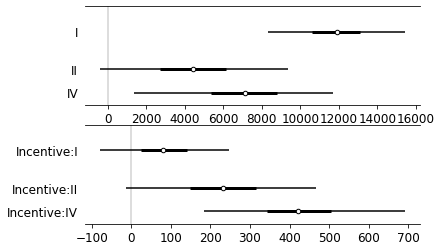

In [535]:
labels=["I","II","IV"]
fig, ax = plt.subplots(2,1)

# az.plot_forest(results4)
az.plot_forest(
    results4rt,
    var_names=["Intercept","ruleStr"],
    hdi_prob=0.95,
    combined=True,
    colors="k",
    ax=ax[0]
)

ax[0].axvline(0,color="lightgrey",zorder=0)
ax[0].set_yticklabels(labels[::-1])
ax[0].set_title("")


az.plot_forest(
    results4rt,
    var_names=["points(?!.*j)"],#,"~subjid","~Intercept","~[II]"], #["~subjid",".*points.*^((?!j).)*$"], #["points","~subjid"], #["points(?!subjid)"],
    filter_vars="regex",
    hdi_prob=0.95,
    combined=True,
    colors="k",
    ax=ax[1]
)

# labels=["I","II","IV"]
# labellist = labels+ ["Incentive:"+a for a in labels]
labellist = ["Incentive:"+a for a in labels]

# print(labellist)
ax[1].set_yticklabels(labellist[::-1])
ax[1].set_title("")
ax[1].axvline(0,color="lightgrey",zorder=0)
# # fig.suptitle("Exp. " + str(1) + " Regression Coefs. on Response Time")

# plt.tight_layout()
plt.show()

EXPERIMENT 6

In [ ]:
# EXPERIMENT 6 (5)

testdata5 = testdf.loc[testdf["expNum"]==5][["subjid","trial","ruleStr","ticketvalue","hitStr","game","rt"]]
learndata5 = learndf.loc[learndf["expNum"]==5][["subjid","trial","ruleStr","ticketvalue","hitStr","game","rt"]]

# ------- performance by incentive
model5a = bmb.Model('hitStr["1"] ~ ruleStr * ticketvalue + (ticketvalue|subjid)', testdata5, family="bernoulli")
print(model5a)
results5a = model5a.fit(draws=1000, chains=4)
az.summary(results5a)

Modeling the probability that hitStr==1


Formula: hitStr["1"] ~ ruleStr * ticketvalue + (ticketvalue|subjid)
Family name: Bernoulli
Link: logit
Observations: 10176
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 4.6284)
    ruleStr ~ Normal(mu: [0. 0.], sigma: [5.3033 5.3844])
    ticketvalue ~ Normal(mu: 0.0, sigma: 4.1322)
    ruleStr:ticketvalue ~ Normal(mu: [0. 0.], sigma: [5.4709 5.5998])

  Group-level effects
    1|subjid ~ Normal(mu: 0, sigma: HalfNormal(sigma: 4.6284))
    ticketvalue|subjid ~ Normal(mu: 0, sigma: HalfNormal(sigma: 4.1322))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, ruleStr, ticketvalue, ruleStr:ticketvalue, 1|subjid_sigma, 1|subjid_offset, ticketvalue|subjid_sigma, ticketvalue|subjid_offset]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4102 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.949,0.318,4.322,5.532,0.007,0.005,2134.0,2746.0,1.0
ruleStr[II],-2.415,0.374,-3.152,-1.747,0.009,0.006,1722.0,2322.0,1.0
ruleStr[IV],-2.065,0.388,-2.831,-1.356,0.010,0.007,1590.0,2019.0,1.0
ticketvalue,0.141,0.236,-0.286,0.581,0.004,0.003,3282.0,2667.0,1.0
ruleStr:ticketvalue[II],0.243,0.275,-0.272,0.733,0.005,0.004,3475.0,2966.0,1.0
...,...,...,...,...,...,...,...,...,...
ticketvalue|subjid[374],-0.210,0.517,-1.206,0.718,0.006,0.008,6717.0,3331.0,1.0
ticketvalue|subjid[375],0.964,0.766,-0.441,2.409,0.009,0.008,6932.0,3262.0,1.0
ticketvalue|subjid[376],0.114,0.741,-1.239,1.530,0.009,0.013,6460.0,2443.0,1.0
ticketvalue|subjid[378],-0.375,0.527,-1.307,0.688,0.006,0.007,7523.0,2712.0,1.0


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'ruleStr\nII'}>,
        <AxesSubplot:title={'center':'ruleStr\nIV'}>],
       [<AxesSubplot:title={'center':'ticketvalue'}>,
        <AxesSubplot:title={'center':'ruleStr:ticketvalue\nII'}>,
        <AxesSubplot:title={'center':'ruleStr:ticketvalue\nIV'}>]],
      dtype=object)

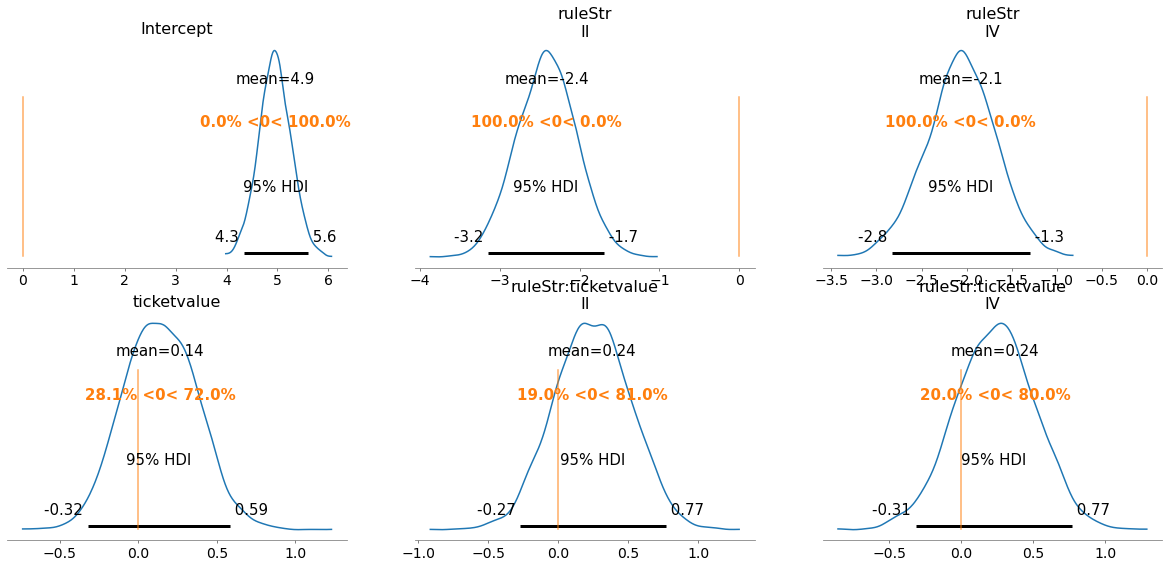

In [ ]:
az.plot_posterior(results5a, var_names=["Intercept","ruleStr","ticketvalue","ruleStr:ticketvalue"], hdi_prob=0.95, ref_val=0)

Text(0.5, 1.0, 'Rule Type IV')

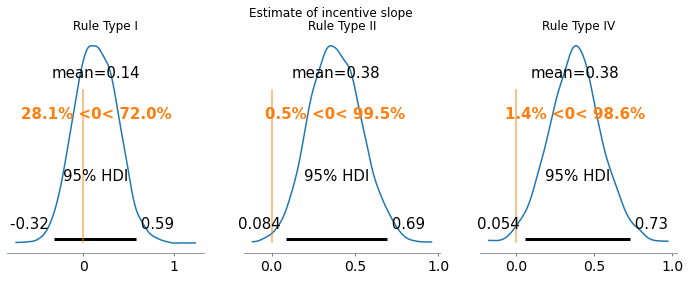

In [ ]:
combo = results5a.posterior["ticketvalue"] + results5a.posterior["ruleStr:ticketvalue"] #.stack(samples=("chain", "draw"))
# comboIV = results5a.posterior["ticketvalue"] + results5a.posterior["ruleStr:ticketvalue"][1] #.stack(samples=("chain", "draw"))
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
az.plot_posterior(results5a.posterior["ticketvalue"], hdi_prob=0.95, ref_val=0, ax=axes[0])
az.plot_posterior(combo[:,:,0], hdi_prob=0.95, ref_val=0, ax=axes[1])
az.plot_posterior(combo[:,:,1], hdi_prob=0.95, ref_val=0, ax=axes[2])

fig.suptitle("Estimate of incentive slope")

axes[0].set_title("Rule Type I")
axes[1].set_title("Rule Type II")
axes[2].set_title("Rule Type IV")



In [ ]:
# ------- performance by incentive
model5b = bmb.Model('hitStr["1"] ~ 0 + ruleStr * ticketvalue + (ticketvalue|subjid)', testdata5, family="bernoulli")
print(model5b)
results5b = model5b.fit(draws=1000, chains=4)
az.summary(results5b)

Modeling the probability that hitStr==1


Formula: hitStr["1"] ~ 0 + ruleStr * ticketvalue + (ticketvalue|subjid)
Family name: Bernoulli
Link: logit
Observations: 10176
Priors:
  Common-level effects
    ruleStr ~ Normal(mu: [0. 0. 0.], sigma: [5.2339 5.3033 5.3844])
    ticketvalue ~ Normal(mu: 0.0, sigma: 4.1322)
    ruleStr:ticketvalue ~ Normal(mu: [0. 0.], sigma: [5.4709 5.5998])

  Group-level effects
    1|subjid ~ Normal(mu: 0, sigma: HalfNormal(sigma: 4.982))
    ticketvalue|subjid ~ Normal(mu: 0, sigma: HalfNormal(sigma: 4.1322))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [ruleStr, ticketvalue, ruleStr:ticketvalue, 1|subjid_sigma, 1|subjid_offset, ticketvalue|subjid_sigma, ticketvalue|subjid_offset]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 518 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ruleStr[I],4.946,0.327,4.351,5.573,0.007,0.005,2237.0,2287.0,1.0
ruleStr[II],2.529,0.235,2.126,2.998,0.007,0.005,1105.0,1967.0,1.0
ruleStr[IV],2.872,0.249,2.384,3.314,0.007,0.005,1273.0,2214.0,1.0
ticketvalue,0.145,0.238,-0.297,0.597,0.004,0.003,2916.0,3002.0,1.0
ruleStr:ticketvalue[II],0.246,0.276,-0.285,0.756,0.005,0.004,3060.0,2991.0,1.0
...,...,...,...,...,...,...,...,...,...
ticketvalue|subjid[374],-0.223,0.511,-1.196,0.728,0.007,0.007,6056.0,3353.0,1.0
ticketvalue|subjid[375],0.948,0.765,-0.511,2.390,0.011,0.009,5180.0,2964.0,1.0
ticketvalue|subjid[376],0.143,0.714,-1.180,1.497,0.010,0.010,5436.0,3161.0,1.0
ticketvalue|subjid[378],-0.366,0.528,-1.423,0.585,0.006,0.007,6701.0,2728.0,1.0


array([[<AxesSubplot:title={'center':'ruleStr\nI'}>,
        <AxesSubplot:title={'center':'ruleStr\nII'}>,
        <AxesSubplot:title={'center':'ruleStr\nIV'}>],
       [<AxesSubplot:title={'center':'ticketvalue'}>,
        <AxesSubplot:title={'center':'ruleStr:ticketvalue\nII'}>,
        <AxesSubplot:title={'center':'ruleStr:ticketvalue\nIV'}>]],
      dtype=object)

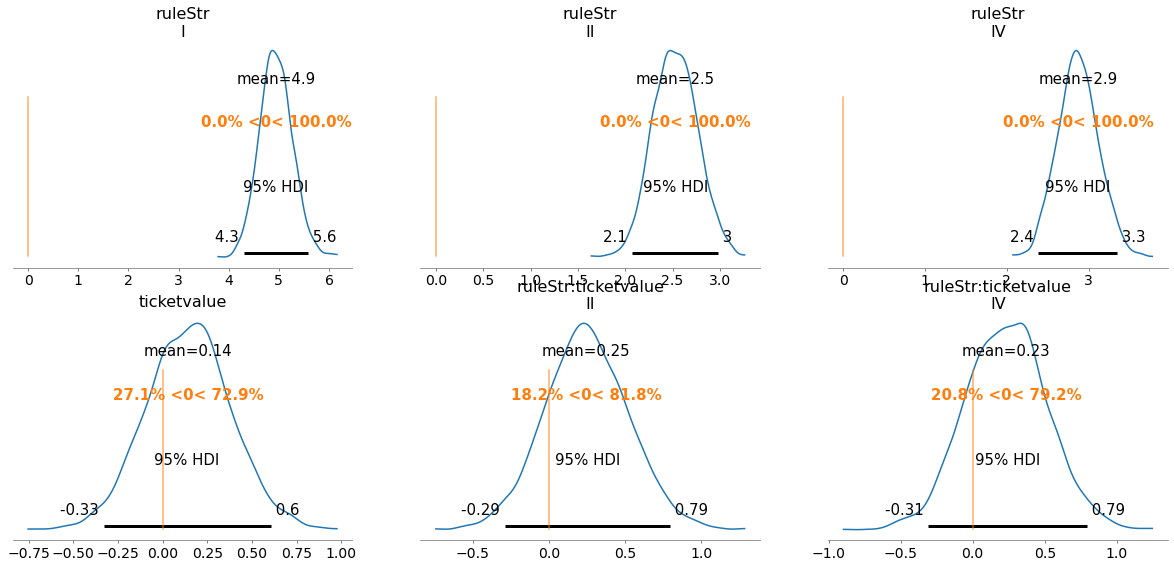

In [ ]:
az.plot_posterior(results5b, var_names=["ruleStr","ticketvalue","ruleStr:ticketvalue"], hdi_prob=0.95, ref_val=0)

In [ ]:
# ------- reaction time
print("Response time by incentive")

model5rt_test = bmb.Model('rt ~ ruleStr * ticketvalue + (ticketvalue|subjid)', testdata5)
results5rt_test = model5rt_test.fit(draws=1000, chains=4)
az.summary(results5rt_test, stat_funcs=func_dict, extend=True)

Response time by incentive


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, ruleStr, ticketvalue, ruleStr:ticketvalue, 1|subjid_sigma, 1|subjid_offset, ticketvalue|subjid_sigma, ticketvalue|subjid_offset, rt_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 497 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,Median,MAD_SD
Intercept,1738.963,365.844,1059.341,2453.599,6.457,4.566,3212.0,3100.0,1.0,1736.526,248.628
ruleStr[II],1043.396,532.708,29.607,2043.634,9.583,6.954,3092.0,2659.0,1.0,1047.680,360.398
ruleStr[IV],1448.709,532.460,559.090,2544.064,9.068,6.446,3445.0,3264.0,1.0,1454.778,357.901
ticketvalue,163.289,546.103,-871.848,1153.468,11.780,8.331,2150.0,2187.0,1.0,173.052,366.604
ruleStr:ticketvalue[II],557.035,781.269,-946.220,1973.252,16.442,12.296,2254.0,2462.0,1.0,573.518,527.663
...,...,...,...,...,...,...,...,...,...,...,...
ticketvalue|subjid[374],-173.903,2342.875,-4693.948,4170.588,31.481,46.160,5504.0,2432.0,1.0,-158.168,1479.344
ticketvalue|subjid[375],-277.082,2358.147,-4784.116,4084.091,31.548,44.564,5595.0,2056.0,1.0,-275.256,1578.183
ticketvalue|subjid[376],-894.070,2353.195,-5243.784,3755.752,35.689,50.988,4328.0,2295.0,1.0,-921.526,1526.286
ticketvalue|subjid[378],-1262.347,2263.984,-5352.228,2964.132,29.752,37.575,5861.0,2863.0,1.0,-1247.998,1588.833


array([[<AxesSubplot:title={'center':'ruleStr\nII'}>,
        <AxesSubplot:title={'center':'ruleStr\nIV'}>,
        <AxesSubplot:title={'center':'ticketvalue'}>],
       [<AxesSubplot:title={'center':'ruleStr:ticketvalue\nII'}>,
        <AxesSubplot:title={'center':'ruleStr:ticketvalue\nIV'}>,
        <AxesSubplot:>]], dtype=object)

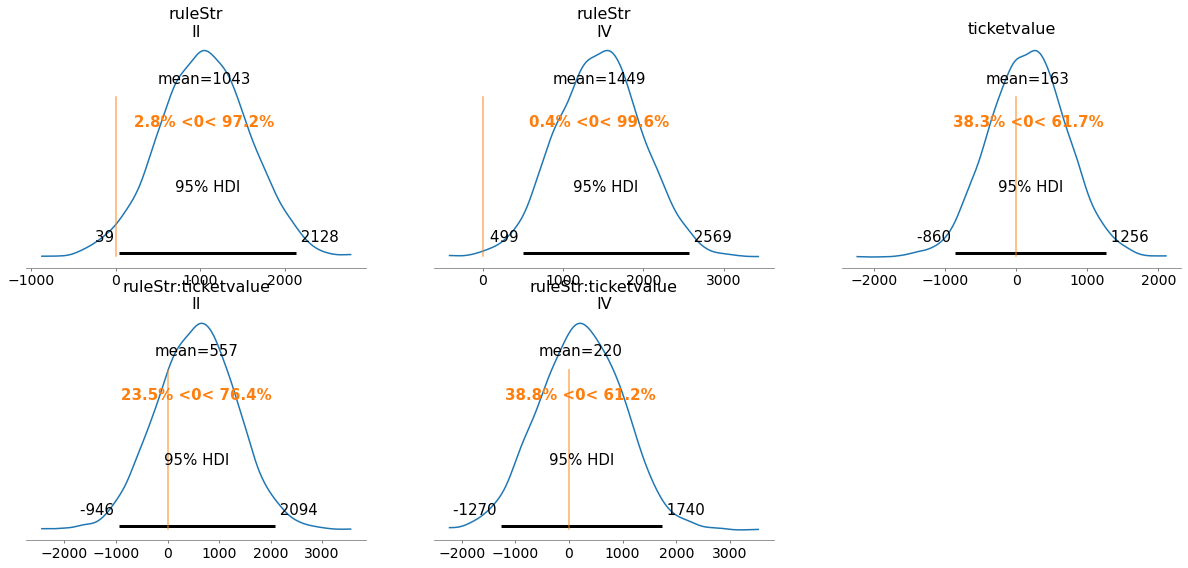

In [ ]:
az.plot_posterior(results5rt_test, var_names=["ruleStr","ticketvalue","ruleStr:ticketvalue"], hdi_prob=0.95, ref_val=0)

Response time in learning phase


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, ruleStr, ticketvalue, ruleStr:ticketvalue, 1|subjid_sigma, 1|subjid_offset, ruleStr|subjid_sigma, ruleStr|subjid_offset, ticketvalue|subjid_sigma, ticketvalue|subjid_offset, rt_sigma]


/anaconda/envs/shj-exp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2446 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<AxesSubplot:title={'center':'ruleStr\nII'}>,
        <AxesSubplot:title={'center':'ruleStr\nIV'}>,
        <AxesSubplot:title={'center':'ticketvalue'}>],
       [<AxesSubplot:title={'center':'ruleStr:ticketvalue\nII'}>,
        <AxesSubplot:title={'center':'ruleStr:ticketvalue\nIV'}>,
        <AxesSubplot:>]], dtype=object)

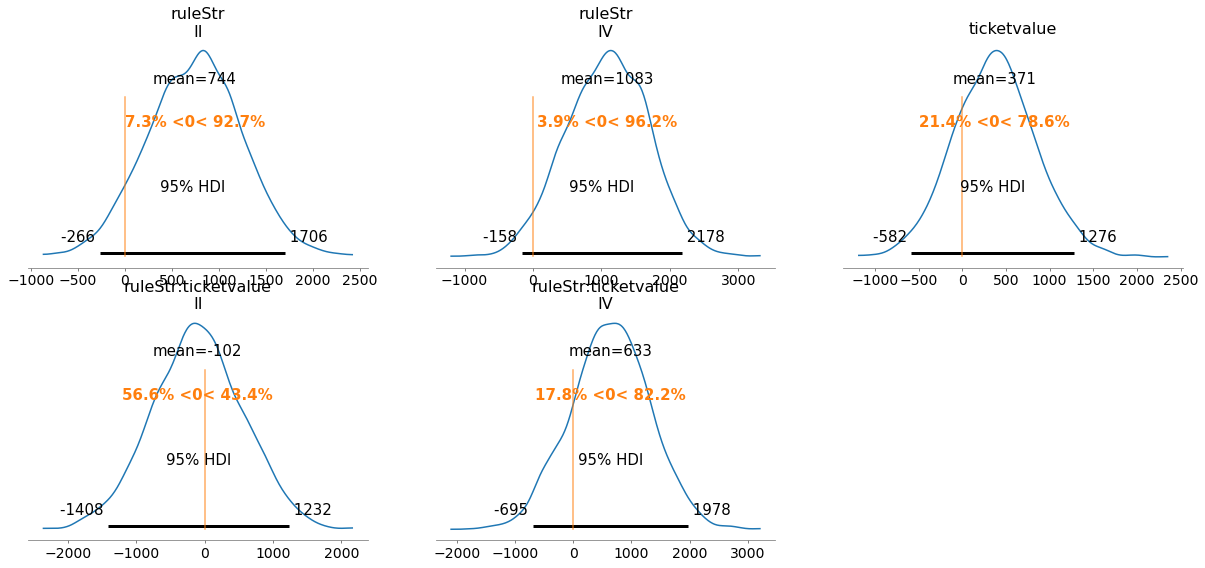

In [ ]:
# ------- reaction time
print("Response time in learning phase")

model5rt_learn = bmb.Model('rt ~ ruleStr * ticketvalue + (ruleStr|subjid) + (ticketvalue|subjid)', learndata5)
results5rt_learn = model5rt_learn.fit(draws=1000, chains=4)
az.summary(results5rt_learn, stat_funcs=func_dict, extend=True)

az.plot_posterior(results5rt_learn, var_names=["ruleStr","ticketvalue","ruleStr:ticketvalue"], hdi_prob=0.95, ref_val=0)

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'ruleStr\nII'}>,
        <AxesSubplot:title={'center':'ruleStr\nIV'}>],
       [<AxesSubplot:title={'center':'ticketvalue'}>,
        <AxesSubplot:title={'center':'ruleStr:ticketvalue\nII'}>,
        <AxesSubplot:title={'center':'ruleStr:ticketvalue\nIV'}>]],
      dtype=object)

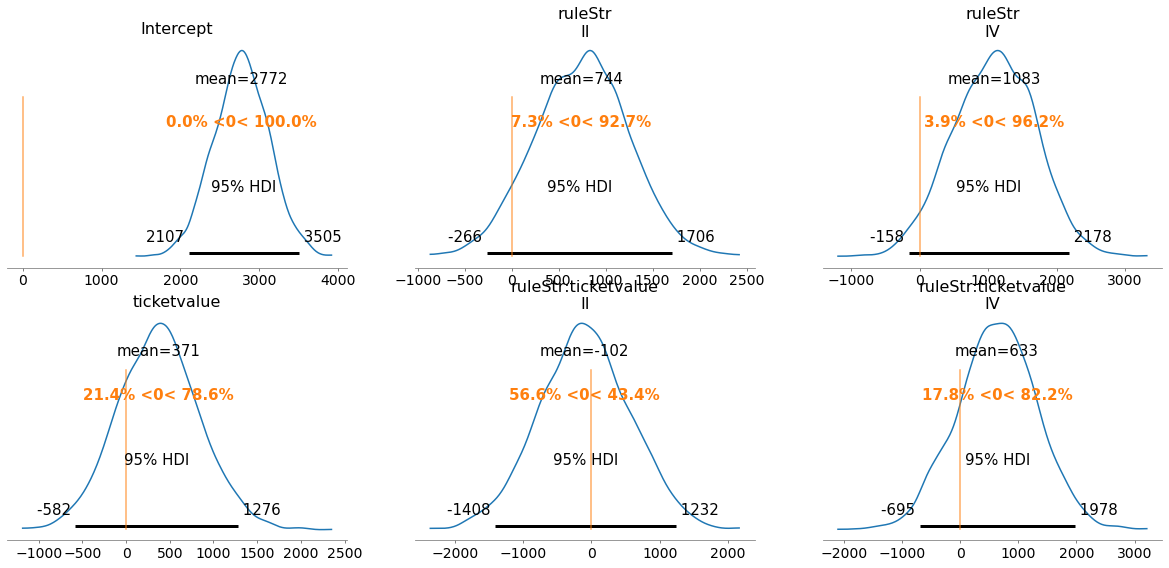

In [ ]:
az.summary(results5rt_learn, stat_funcs=func_dict, extend=True)
az.plot_posterior(results5rt_learn, var_names=["Intercept","ruleStr","ticketvalue","ruleStr:ticketvalue"], hdi_prob=0.95, ref_val=0)

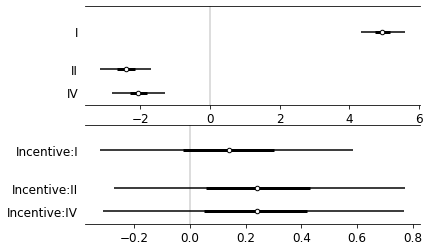

In [536]:
labels=["I","II","IV"]
fig, ax = plt.subplots(2,1)

# az.plot_forest(results4)
az.plot_forest(
    results5a,
    var_names=["Intercept","ruleStr"],
    hdi_prob=0.95,
    combined=True,
    colors="k",
    ax=ax[0]
)

ax[0].axvline(0,color="lightgrey",zorder=0)
ax[0].set_yticklabels(labels[::-1])
ax[0].set_title("")


az.plot_forest(
    results5a,
    var_names=["ticketvalue(?!.*j)"],#,"~subjid","~Intercept","~[II]"], #["~subjid",".*points.*^((?!j).)*$"], #["points","~subjid"], #["points(?!subjid)"],
    filter_vars="regex",
    hdi_prob=0.95,
    combined=True,
    colors="k",
    ax=ax[1]
)

# labels=["I","II","IV"]
# labellist = labels+ ["Incentive:"+a for a in labels]
labellist = ["Incentive:"+a for a in labels]

# print(labellist)
ax[1].set_yticklabels(labellist[::-1])
ax[1].set_title("")
ax[1].axvline(0,color="lightgrey",zorder=0)
# # fig.suptitle("Exp. " + str(1) + " Regression Coefs. on Response Time")

# plt.tight_layout()
plt.show()

In [ ]:

# def get_predictions(model, idata, seq, rule):
#     # subids = testdata5.query("ruleStr=='"+rule+"'")['subjid'].unique()


#     # Create a data frame with the new data
#     new_data = pd.DataFrame({"ticketvalue": seq, "ruleStr": rule})

#     # Predict probability of dying using out of sample data
#     model.predict(idata, data=new_data)

#     # Stack chains and draws
#     posterior = idata.posterior["hitStr_mean"].stack(samples=("chain", "draw"))
#     # Get posterior mean across all draws
#     mu = posterior.mean(axis=1)
#     return mu

# x_seq = np.linspace(0, 2, num=200)
# # inverse of the logit function

# mu_logit_1 = get_predictions(model5group, results5group, x_seq, "I")
# mu_logit_2 = get_predictions(model5group, results5group, x_seq, "II")
# mu_logit_4 = get_predictions(model5group, results5group, x_seq, "IV")


# plt.plot(x_seq, mu_logit_1, lw=2, label="I")
# plt.plot(x_seq, mu_logit_2, lw=2, label="II")
# plt.plot(x_seq, mu_logit_4, lw=2, label="IV")
# plt.axhline(0.5, c="k", alpha=0.5, ls="--")
# plt.xlabel("Incentive")
# plt.ylabel("Probability correct")
# plt.legend();


In [ ]:
# t-tests

bonus_df = df.loc[(df["phase"]=="bonus") & (df["expNum"]==5)]
bonus_df = bonus_df[['subjid', 'game', 'ticketvalue', 'ruleStr', 'testscore','bonus','totalbonustodate']]
bonus_df["percentcorrect"]=bonus_df["testscore"]/8
# display(bonus_df)

df_type1 = bonus_df.loc[df["ruleStr"]=="I"]
df_type2 = bonus_df.loc[df["ruleStr"]=="II"]
df_type4 = bonus_df.loc[df["ruleStr"]=="IV"]


results = pg.ttest(df_type1["testscore"].loc[(df_type1["ticketvalue"]==0.02)], df_type1["testscore"].loc[(df_type1["ticketvalue"]==1.23)], paired=True, alternative="less")
results

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.77709,223,less,0.781035,"[-inf, 0.2]",0.056466,0.201,0.006434


In [ ]:
results = pg.ttest(df_type2["testscore"].loc[(df_type2["ticketvalue"]==0.02)], df_type2["testscore"].loc[(df_type2["ticketvalue"]==1.23)], paired=True, alternative="less")
results

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.692237,211,less,0.046039,"[-inf, -0.0]",0.118714,0.625,0.53113


In [ ]:
results = pg.ttest(df_type4["testscore"].loc[(df_type4["ticketvalue"]==0.02)], df_type4["testscore"].loc[(df_type4["ticketvalue"]==1.23)], paired=True, alternative="less")
results

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.239347,199,less,0.108338,"[-inf, 0.05]",0.089343,0.336,0.349878


In [ ]:
df_test1 = testdata5.loc[df["ruleStr"]=="I"]
df_test2 = testdata5.loc[df["ruleStr"]=="II"]
df_test4 = testdata5.loc[df["ruleStr"]=="IV"]
df_ln1 = learndata5.loc[df["ruleStr"]=="I"]
df_ln2 = learndata5.loc[df["ruleStr"]=="II"]
df_ln4 = learndata5.loc[df["ruleStr"]=="IV"]

print("TESTING PHASE RTs")

results1t = pg.ttest(df_test1["rt"].loc[(df_test1["ticketvalue"]==0.02)], df_test1["rt"].loc[(df_test1["ticketvalue"]==1.23)], paired=True, alternative="less")
display(results1t)

results2t = pg.ttest(df_test2["rt"].loc[(df_test2["ticketvalue"]==0.02)], df_test2["rt"].loc[(df_test2["ticketvalue"]==1.23)], paired=True, alternative="less")
display(results2t)

results4t = pg.ttest(df_test4["rt"].loc[(df_test4["ticketvalue"]==0.02)], df_test4["rt"].loc[(df_test4["ticketvalue"]==1.23)], paired=True, alternative="less")
display(results4t)

print("LEARNING PHASE RTs")

results1l = pg.ttest(df_ln1["rt"].loc[(df_ln1["ticketvalue"]==0.02)], df_ln1["rt"].loc[(df_ln1["ticketvalue"]==1.23)], paired=True, alternative="less")
display(results1l)

results2l = pg.ttest(df_ln2["rt"].loc[(df_ln2["ticketvalue"]==0.02)], df_ln2["rt"].loc[(df_ln2["ticketvalue"]==1.23)], paired=True, alternative="less")
display(results2l)

results4l = pg.ttest(df_ln4["rt"].loc[(df_ln4["ticketvalue"]==0.02)], df_ln4["rt"].loc[(df_ln4["ticketvalue"]==1.23)], paired=True, alternative="less")
display(results4l)

TESTING PHASE RTs


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.311847,1791,less,0.01045,"[-inf, -60.74]",0.067831,0.764,0.889805


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.171543,1695,less,0.120773,"[-inf, 356.55]",0.040064,0.109,0.501762


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.828114,1599,less,0.203865,"[-inf, 446.9]",0.02912,0.079,0.315421


LEARNING PHASE RTs


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.265023,7167,less,0.102952,"[-inf, 137.87]",0.021013,0.059,0.553316


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.514245,6783,less,0.065005,"[-inf, 29.23]",0.025302,0.086,0.669647


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.502912,6399,less,0.066456,"[-inf, 114.17]",0.026516,0.087,0.683029


In [ ]:
results5 = results5a

In [ ]:
# EXPORT THE RESULTS TO data.tex
# index in variable name is 0-indexed number of experiment
# exp 1,  exp 2,  exp 3,  exp4,   exp5,   exp6
# model0, model1, model2, model3, model4, model5

# results0 = logistic regression of incentive and rule type on performance
# results0rt_test = linear regression of incentive and rule type on RT in test phase
# results0rt_learn = linear regression of incentive and rule type on RT in learning phase

# NOTE: exp5 has a unique design, so only has results4 and results4rt (no separate learning and test phases)

# coefsX = az.summary(resultsX)
# coefsXrt_test = az.summary(resultsXrt_test)
# coefsXrt_learn = az.summary(resultsXrt_learn)
# coefs4rt = az.summary(results4rt)

# az.hdi(results0.posterior["Intercept"], hdi_prob=0.95)

# Exp 1 fitted regression coefficients
coefs0 = az.summary(results0)
coefs0rt_test = az.summary(results0rt_test,stat_funcs=func_dict, extend=True)
coefs0rt_learn = az.summary(results0rt_learn,stat_funcs=func_dict, extend=True)

# Exp 2 fitted regression coefficients
coefs1 = az.summary(results1)
coefs1rt_test = az.summary(results1rt_test,stat_funcs=func_dict, extend=True)
coefs1rt_learn = az.summary(results1rt_learn,stat_funcs=func_dict, extend=True)

# Exp 3 fitted regression coefficients
coefs2 = az.summary(results2)
coefs2rt_test = az.summary(results2rt_test,stat_funcs=func_dict, extend=True)
coefs2rt_learn = az.summary(results2rt_learn,stat_funcs=func_dict, extend=True)

# Exp 4 fitted regression coefficients
coefs3 = az.summary(results3)
coefs3rt_test = az.summary(results3rt_test,stat_funcs=func_dict, extend=True)
coefs3rt_learn = az.summary(results3rt_learn,stat_funcs=func_dict, extend=True)

# Exp 5 fitted regression coefficients
coefs4 = az.summary(results4)
coefs4rt = az.summary(results4rt,stat_funcs=func_dict, extend=True)

# Exp 6 fitted regression coefficients
coefs5 = az.summary(results5)
coefs5rt_test = az.summary(results5rt_test,stat_funcs=func_dict, extend=True)
coefs5rt_learn = az.summary(results5rt_learn,stat_funcs=func_dict, extend=True)

# resultslist = [results0, results0rt_test, results0rt_learn, 
# results1, results1rt_test, results1rt_learn, 
# results2, results2rt_test, results2rt_learn, 
# results3, results3rt_test, results3rt_learn, 
# results4, results4rt, 
# results5, results5rt_test, results5rt_learn ]
fnamelist = ['results0', 'results0rt_test', 'results0rt_learn', 
'results1', 'results1rt_test', 'results1rt_learn', 
'results2', 'results2rt_test', 'results2rt_learn', 
'results3', 'results3rt_test', 'results3rt_learn', 
'results4', 'results4rt', 
'results5', 'results5rt_test', 'results5rt_learn' ]

coefslist = [coefs0, coefs0rt_test, coefs0rt_learn, 
coefs1, coefs1rt_test, coefs1rt_learn, 
coefs2, coefs2rt_test, coefs2rt_learn, 
coefs3, coefs3rt_test, coefs3rt_learn, 
coefs4, coefs4rt, 
coefs5, coefs5rt_test, coefs5rt_learn ]

coefs0


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.196,0.258,1.700,2.727,0.009,0.006,794.0,1303.0,1.0
ruleStr[II],-0.808,0.311,-1.449,-0.237,0.010,0.007,1026.0,1583.0,1.0
ruleStr[III],-1.097,0.316,-1.696,-0.467,0.010,0.007,1042.0,1567.0,1.0
ruleStr[IV],-0.756,0.315,-1.336,-0.107,0.010,0.007,990.0,1782.0,1.0
ruleStr[V],-1.044,0.312,-1.676,-0.446,0.010,0.007,994.0,1445.0,1.0
ruleStr[VI],-1.591,0.294,-2.162,-1.036,0.010,0.007,959.0,1456.0,1.0
incentive,0.016,0.013,-0.009,0.043,0.000,0.000,807.0,1336.0,1.0
ruleStr:incentive[II],-0.026,0.016,-0.057,0.004,0.000,0.000,1015.0,1556.0,1.0
ruleStr:incentive[III],-0.027,0.016,-0.058,0.003,0.000,0.000,1046.0,1559.0,1.0
ruleStr:incentive[IV],-0.026,0.016,-0.056,0.005,0.001,0.000,913.0,1570.0,1.0


In [ ]:
# coefs0[["mean","sd","hdi_2.5%","hdi_97.5%"]]
# coefs4rt[["Median","MAD_SD","hdi_2.5%","hdi_97.5%"]]

import os  
os.makedirs("regression_results", exist_ok=True)  

allresults = dict(zip(fnamelist,coefslist))

for fname, coefs in allresults.items():
    full_fname = "regression_results/" +fname + ".csv"
    if "rt" in fname: 
        columns=["Median","MAD_SD","hdi_2.5%","hdi_97.5%"]
    else: 
        columns=["mean","sd","hdi_2.5%","hdi_97.5%"]

    non_subj_rows = [True if "subjid" not in i else False for i in coefs.index.to_numpy()]
    coefs.loc[non_subj_rows][columns].to_csv(full_fname)

In [278]:
# coefs5.loc["subjid" not in coefs5.index]["mean","sd","hdi_2.5%","hdi_97.5%"]
idx = [True if "subjid" not in i else False for i in coefs5.index.to_numpy()]
coefs5.loc[idx][["mean","sd","hdi_2.5%","hdi_97.5%"]]

,mean,sd,hdi_2.5%,hdi_97.5%
Intercept,4.949,0.318,4.336,5.597
ruleStr[II],-2.415,0.374,-3.152,-1.691
ruleStr[IV],-2.065,0.388,-2.830,-1.294
ticketvalue,0.141,0.236,-0.322,0.585
ruleStr:ticketvalue[II],0.243,0.275,-0.272,0.772
ruleStr:ticketvalue[IV],0.237,0.279,-0.314,0.769


In [274]:
coefs5.index.to_numpy()

array(['Intercept', 'ruleStr[II]', 'ruleStr[IV]', 'ticketvalue',
       'ruleStr:ticketvalue[II]', 'ruleStr:ticketvalue[IV]',
       '1|subjid_sigma', 'ticketvalue|subjid_sigma', '1|subjid[0]',
       '1|subjid[2]', '1|subjid[3]', '1|subjid[4]', '1|subjid[5]',
       '1|subjid[6]', '1|subjid[8]', '1|subjid[10]', '1|subjid[11]',
       '1|subjid[13]', '1|subjid[14]', '1|subjid[16]', '1|subjid[17]',
       '1|subjid[18]', '1|subjid[19]', '1|subjid[20]', '1|subjid[21]',
       '1|subjid[22]', '1|subjid[23]', '1|subjid[24]', '1|subjid[25]',
       '1|subjid[26]', '1|subjid[27]', '1|subjid[29]', '1|subjid[30]',
       '1|subjid[31]', '1|subjid[32]', '1|subjid[33]', '1|subjid[34]',
       '1|subjid[36]', '1|subjid[37]', '1|subjid[38]', '1|subjid[40]',
       '1|subjid[41]', '1|subjid[42]', '1|subjid[43]', '1|subjid[44]',
       '1|subjid[45]', '1|subjid[46]', '1|subjid[47]', '1|subjid[49]',
       '1|subjid[50]', '1|subjid[51]', '1|subjid[52]', '1|subjid[53]',
       '1|subjid[54]', '1|subji

In [46]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Aug 16 2022

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 7.31.1

numpy      : 1.21.5
seaborn    : 0.11.2
scipy      : 1.7.3
matplotlib : 3.5.1
statsmodels: 0.13.2
sys        : 3.7.13 (default, Mar 28 2022, 07:24:34) 
[Clang 12.0.0 ]
arviz      : 0.12.1
pingouin   : 0.5.1
bambi      : 0.9.0
pandas     : 1.3.5

Watermark: 2.3.0

